# Corporacion Favorita Grocery Sales Forecasting

## 1.1 Problem definition

In this project, you will predict future sales based on historical data. There is a lot of signal in the historical data about future sales - average sales across various periods, trends, seasonality... However, this information needs to be extracted from data by creating new features. You will really get your hands dirty with data on this one!

It is extremely important to use a correct validation schema when working with time series data. One cannot just use a random split as that would mean that a ML model uses information from the future (e.g. sales at a different store but from the same time period). Training/validation split needs to be based on time with validation set being the more fresh dataset.  

## 2.1 Dataset

https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import random
# Input data files are available in the read-only "./input/" directory

## 2.2 Data Loading

In [2]:
items = pd.read_csv("./input/items.csv")
holiday_events = pd.read_csv("./input/holidays_events.csv")
stores = pd.read_csv("./input/stores.csv")
oil = pd.read_csv("./input/oil.csv")
transactions = pd.read_csv("./input/transactions.csv")
transactions_df=transactions.copy(deep=True)
# the full training data's output: "125,497,040 rows | 6 columns"
# Therefore we will only load approx 0.02% of the data just to get a rough idea of what is in store for us.
# dataframe for data visualization
train = pd.read_csv("./input/train.csv", nrows=254000)

In [3]:
filename = "./input/train.csv"
# skip initial 8M records as they are too old for training
# input dataframe for modelling
train_large = pd.read_csv(filename, skiprows=8000000,names = train.columns)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# sort by date to get time series pattern
train_large = train_large.sort_values(by="date")

In [5]:
#randomly choose 1M size dataset for Train as it is observed that going above is not really helping the model.
train_large=train_large.sample(1000000, replace=False)

In [6]:
train_large['date'].unique()

array(['2016-08-11', '2014-12-06', '2016-05-07', ..., '2017-01-01',
       '2014-01-01', '2016-01-01'], dtype=object)

In [7]:
train_large.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
79728076,87728075,2016-08-11,44,1584305,1.0,False
28804655,36804654,2014-12-06,53,1464258,1.0,False
70529780,78529779,2016-05-07,49,268443,27.0,False
45471536,53471535,2015-08-09,3,1038952,12.0,False
6661871,14661870,2013-11-28,44,1221054,1.0,NaN


In [9]:
oil['date'].unique()

array(['2013-01-01', '2013-01-02', '2013-01-03', ..., '2017-08-29',
       '2017-08-30', '2017-08-31'], dtype=object)

In [10]:
train_large.shape

(1000000, 6)

In [11]:
train_large['date'].nunique()

1497

In [12]:
train_large['date'].unique()

array(['2016-08-11', '2014-12-06', '2016-05-07', ..., '2017-01-01',
       '2014-01-01', '2016-01-01'], dtype=object)

In [13]:
train_large.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
79728076,87728075,2016-08-11,44,1584305,1.0,False
28804655,36804654,2014-12-06,53,1464258,1.0,False
70529780,78529779,2016-05-07,49,268443,27.0,False
45471536,53471535,2015-08-09,3,1038952,12.0,False
6661871,14661870,2013-11-28,44,1221054,1.0,NaN


In [14]:
train_large.dtypes

id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
dtype: object

In [15]:
train_large['date'].nunique()

1497

## 3 Exploratory Data Analysis 

In [16]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt
color = sns.color_palette()

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template

### Getting familiar with the data

Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
Negative values of unit_sales represent returns of that particular item.
The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
Approximately 16% of the onpromotion values in this file are NaN.

In [17]:
train.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')

In [18]:
train_large.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')

In [19]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))

Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


 The only missing data occurs in the oil data file, which provides the historical daily price for oil.

## 3.1 Oil Data

Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [20]:
oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


In [21]:
 trace = go.Scatter(
     name='Oil prices',
     x=oil['date'],
     y=oil['dcoilwtico'].dropna(), #drop rows which contain missing values.
     mode='lines',
     line=dict(color='rgb(20, 15, 200, 0.8)'),
     #fillcolor='rgba(68, 68, 68, 0.3)',
     fillcolor='rgba(0, 0, 216, 0.3)',
     fill='tonexty' )

 data = [trace]

 layout = go.Layout(
     yaxis=dict(title='Daily Oil price'),
     title='Daily oil prices from Jan 2013 till July 2017',
     showlegend = False)
 fig = go.Figure(data=data, layout=layout)
 py.iplot(fig, filename='pandas-time-series-error-bars')

From January 2013 to July 2017, this graph demonstrates that the daily oil price has been on a declining trend. Whereas the price of oil began 2013 by rising and even breaking the $100 barrier for a few months in 2013, the price of oil began to plummet in the middle of 2014, resulting in a significant decline in the price of oil. This trend appears to be true based on some quick open-source research (i.e. Googling), as oil prices were relatively stable from 2010 to mid-2014, after which they drastically fell (due to a confluence of factors including weak demand due to poor economic growth and surging alternative crude oil sources such as shale/tar sands).

## 3.2 Stores Data

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

In [22]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


Discussion on incorporating feature 'store_age' to the model input:

Having feature like 'store_age' or 'open_year' in input train might help model in understanding and getting business lifecycle pattern out of the data. But I also feel it would be redundant as we already have store specific feature 'store_nbr'(unique id of a given store).

In [25]:
stores.city.value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Ambato            2
Machala           2
Latacunga         2
Manta             2
Salinas           1
Cayambe           1
Libertad          1
Guaranda          1
Loja              1
Puyo              1
Quevedo           1
Babahoyo          1
Esmeraldas        1
El Carmen         1
Daule             1
Ibarra            1
Riobamba          1
Playas            1
Name: city, dtype: int64

Treemaps display hierarchical (tree-structured) data as a set of nested rectangles. Each branch of the tree is given a rectangle, which is then tiled with smaller rectangles representing sub-branches. A leaf node’s rectangle has an area proportional to a specified dimension of the data. Often the leaf nodes are colored to show a separate dimension of the data.
Reference: https://jingwen-z.github.io/data-viz-with-matplotlib-series5-treemap/

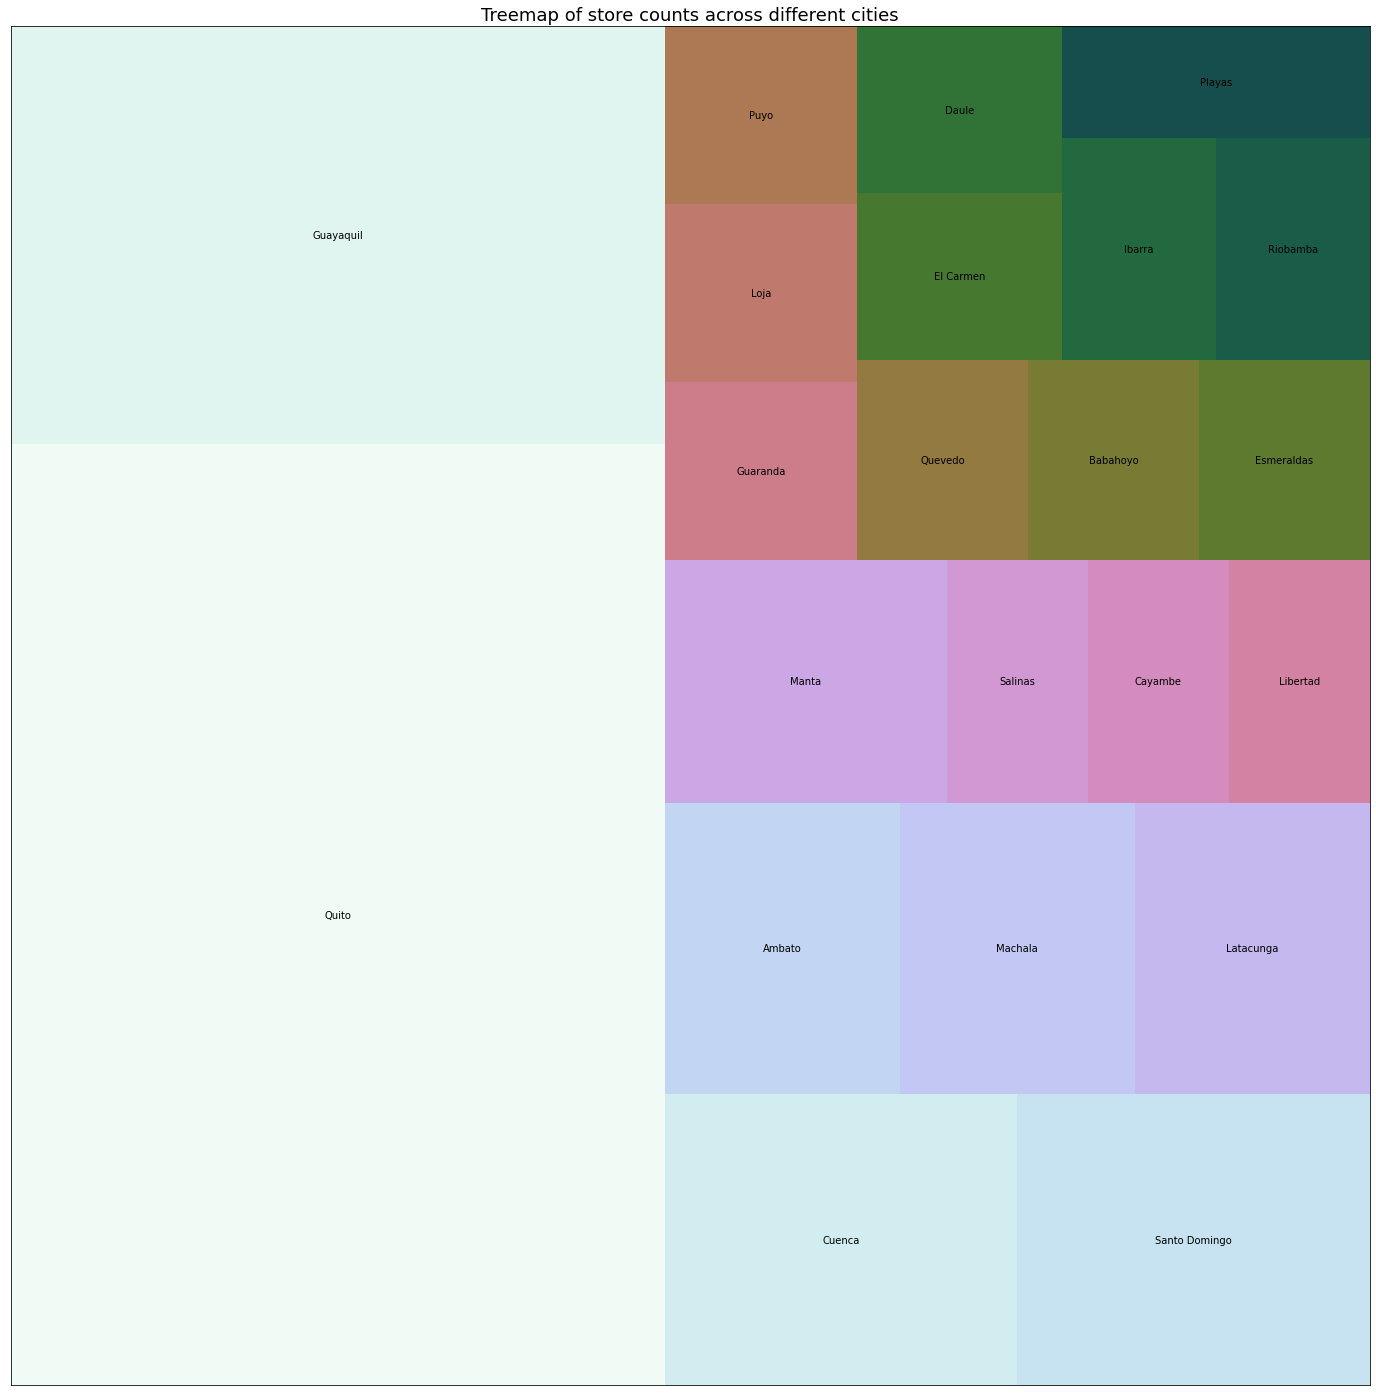

In [26]:
fig = plt.figure(figsize=(25, 21))
location=stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=location['city'].values,label=location.index,
              color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different cities", fontsize=18)
plt.show();

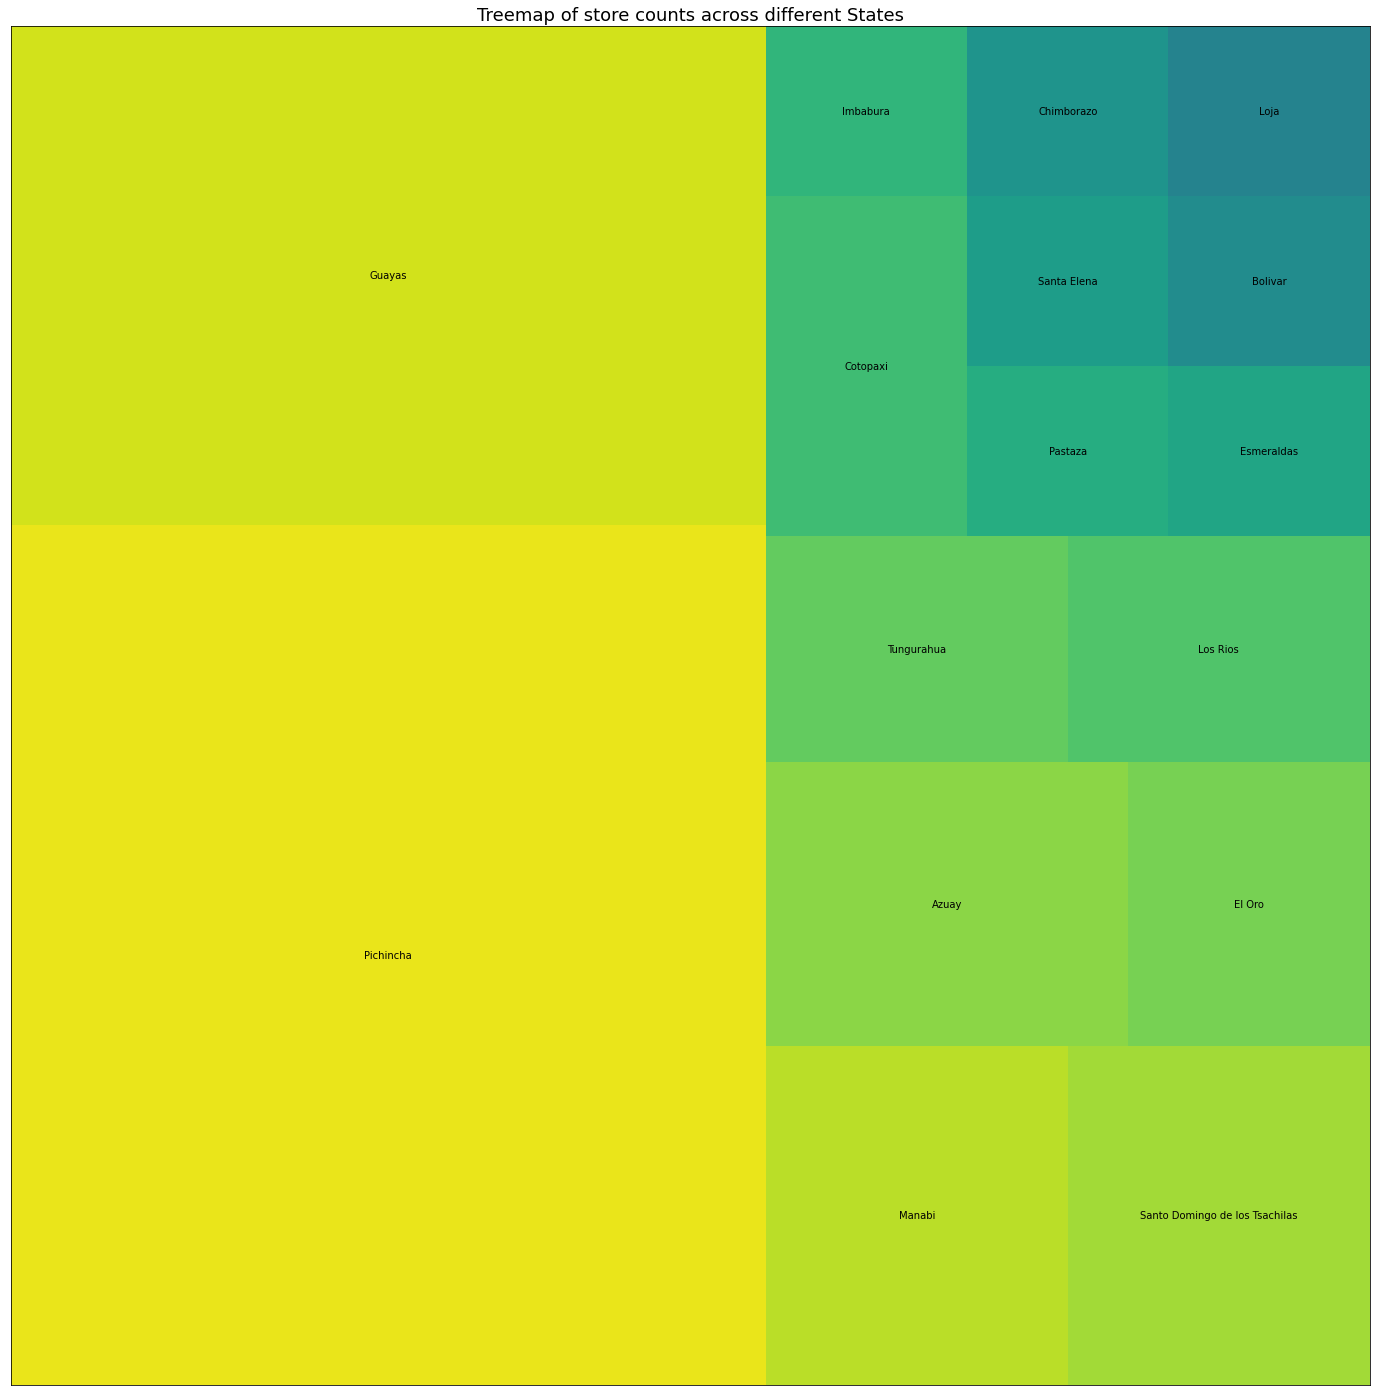

In [27]:
fig = plt.figure(figsize=(25, 21))
location=stores.state.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=location['state'].values,label=location.index,
              color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different States", fontsize=18)
plt.show()

In [28]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Our store numbers will now be arranged against their corresponding shop clusters, allowing us to see whether there are any obvious trends or links in the data. To do so, I'll use the groupby and pivot statements to group our stores Python dataframe based on the values "store nbr" and "cluster." Then I'll unstack the grouping by pivoting on the level of store nbr index labels, yielding a DataFrame with a new level of columns that are the store clusters whose inner-most level pertain to the pivoted store nbr index labels. This method is widely used in Python to create stacked barplots, but because we just have unique store nbr numbers, we'll just receive barplots of store numbers arranged by their relevant clusters.

In [29]:
stores.cluster.unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17])

In [30]:
stores.store_nbr.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [31]:
neworder = [23, 24, 26, 36, 41, 15, 29, 31, 32, 34, 39, 
            53, 4, 37, 40, 43, 8, 10, 19, 20, 33, 38, 13, 
            21, 2, 6, 7, 3, 22, 25, 27, 28, 30, 35, 42, 44, 
            48, 51, 16, 0, 1, 5, 52, 45, 46, 47, 49, 9, 11, 12, 14, 18, 17, 50]

Text(0.5, 1.0, 'Store numbers and the clusters they are assigned to')

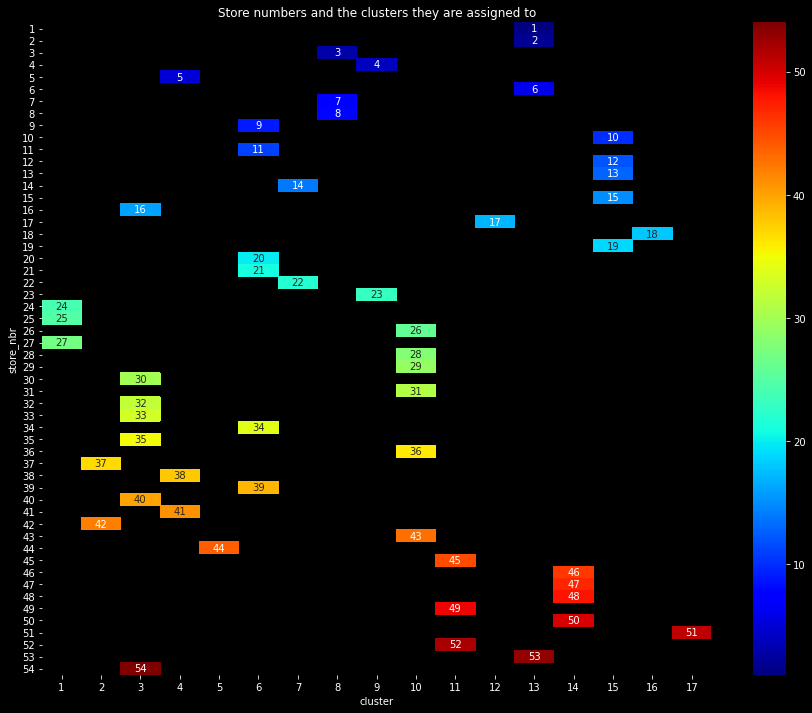

In [32]:
# Finally plot the seaborn heatmap
# cluster vs store_num
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot("store_nbr","cluster", "store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')

In [33]:
stores.groupby(['cluster']).size()

cluster
1     3
2     2
3     7
4     3
5     1
6     6
7     2
8     3
9     2
10    6
11    3
12    1
13    4
14    4
15    5
16    1
17    1
dtype: int64

In [34]:
nbr_cluster = stores.groupby(['store_nbr','cluster']).size()
nbr_cluster.unstack().head()

cluster,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
store_nbr,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


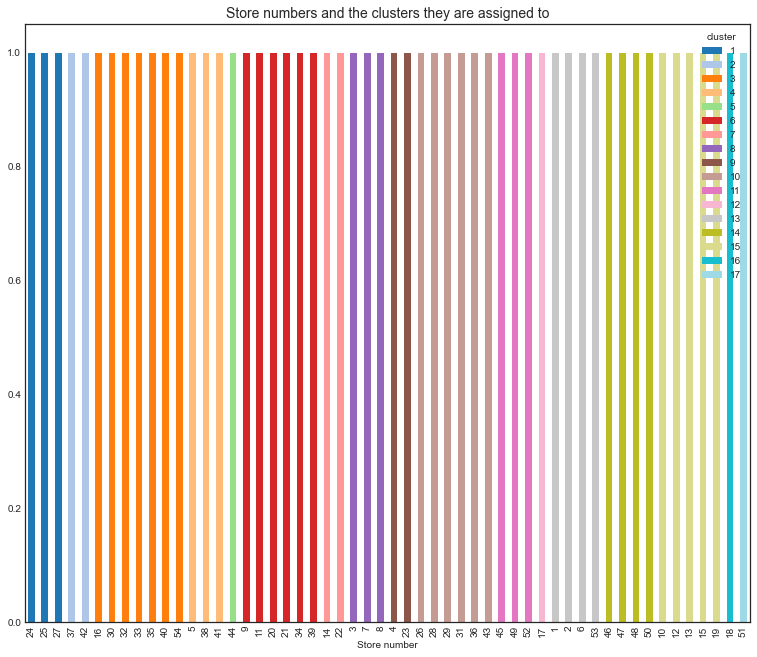

In [35]:
 #cluster vs store_num
 plt.style.use('seaborn-white')
 nbr_cluster = stores.groupby(['store_nbr','cluster']).size()
 nbr_cluster.unstack().iloc[neworder].plot(kind='bar',stacked=True, colormap= 'tab20', figsize=(13,11),  grid=False)
 plt.title('Store numbers and the clusters they are assigned to', fontsize=14)
 plt.ylabel('')
 plt.xlabel('Store number')
 plt.show()

From visualising the store numbers side-by-side based on the clustering, we can identify certain patterns. 
For example clusters 3, 6, 10 and 15 are the most common store clusters based off the fact that there are more store_nbrs attributed to them then the others 
while on the other end of the spectrum, we have clusters 5 and 17 which are only related to the stores 44 and 51 respectively.

we can look at the distribution of clusters based on the store type to see if we can identify any apparent relationship between types and the way the company has decided to cluster the particular store.

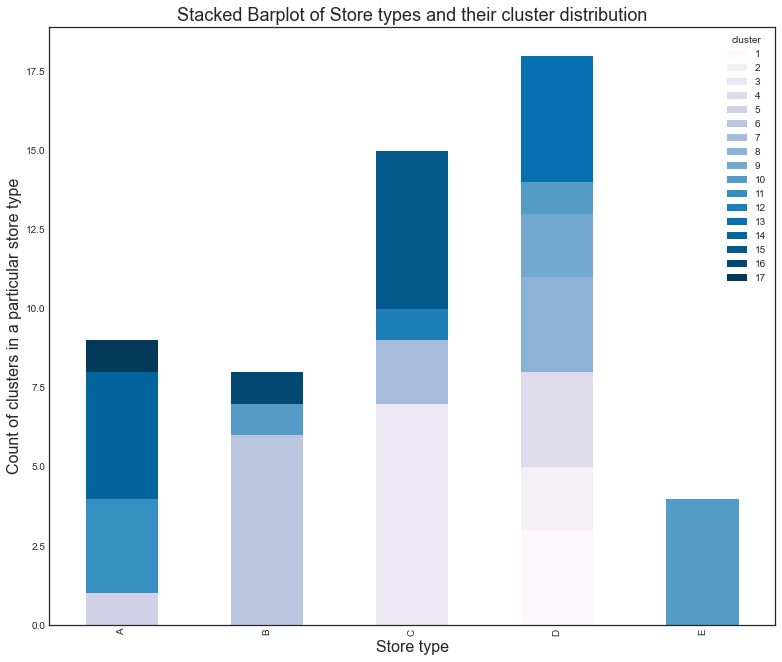

In [36]:
#cluster vs store_type
plt.style.use('seaborn-white')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

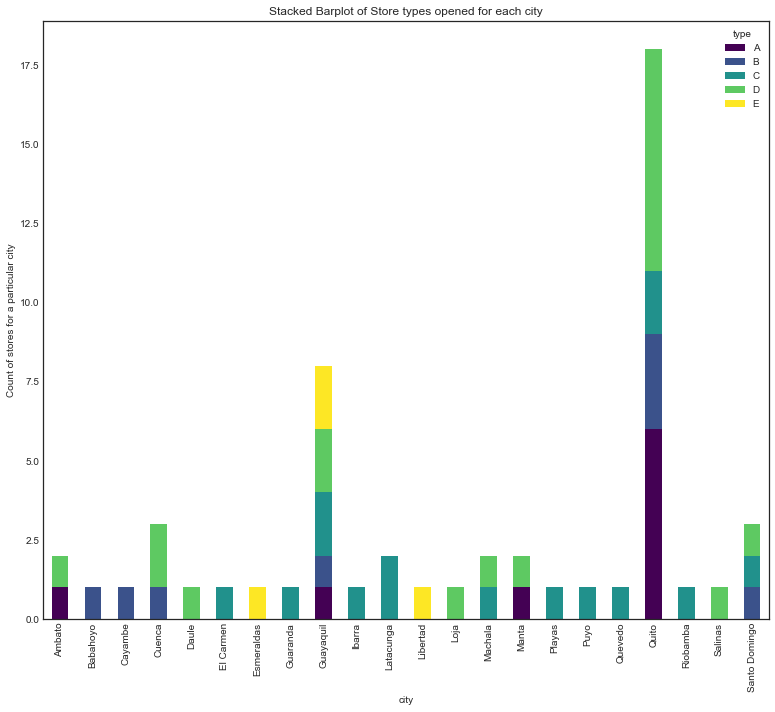

In [37]:
#city vs store_type
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

Guayaquil and Quito are two cities that stand out in terms of the range of retail kinds available. These are unsurprising given that Quito is Ecuador's capital and Guayaquil is the country's largest and most populated metropolis. As a result, one might expect Corporacion Favorita to target these major cities with the most diverse store types, as evidenced by the highest counts of store nbrs attributed to those two cities.

## 3.3 Holiday Events Data

Holidays and Events, with metadata
A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [38]:
holiday_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [39]:
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

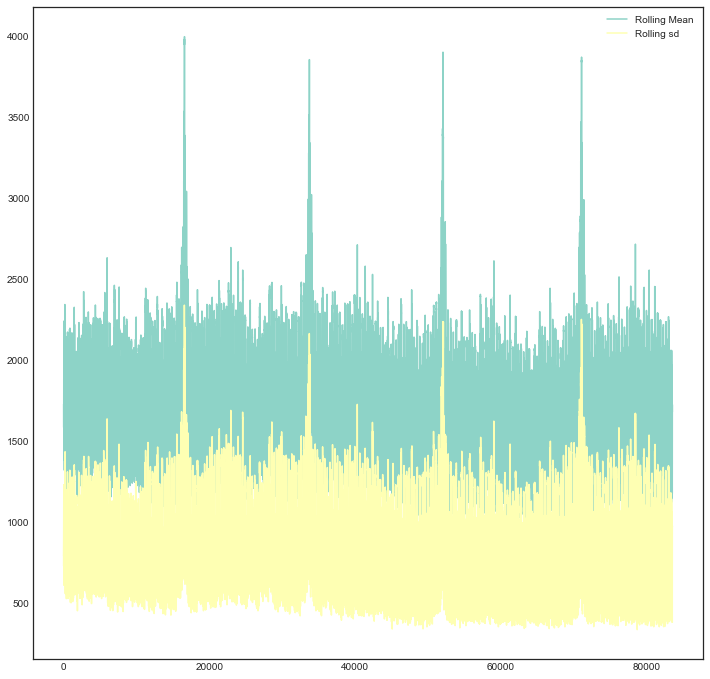

In [40]:
#does the transactions peak at holiday events?
plt.figure(figsize=(12,12))
plt.plot(transactions['transactions'].rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(transactions['transactions'].rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

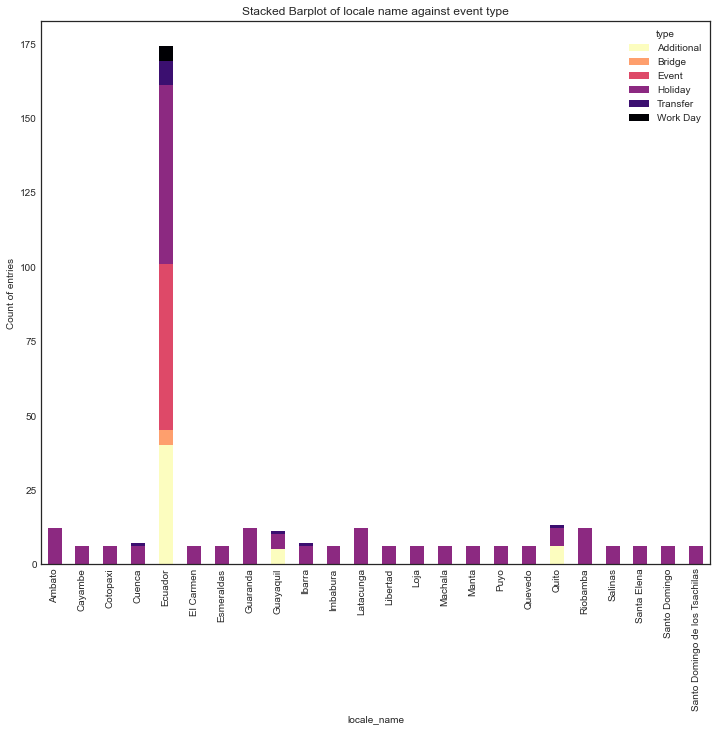

In [41]:
plt.style.use('seaborn-white')
holiday_local_type = holiday_events.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

In [42]:
 with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
     print(holiday_events[['type','description']].apply(pd.Series.value_counts))

                                                  type  description
Additional                                        51.0          NaN
Batalla de Pichincha                               NaN          5.0
Black Friday                                       NaN          3.0
Bridge                                             5.0          NaN
Cantonizacion de Cayambe                           NaN          6.0
Cantonizacion de El Carmen                         NaN          6.0
Cantonizacion de Guaranda                          NaN          6.0
Cantonizacion de Latacunga                         NaN          6.0
Cantonizacion de Libertad                          NaN          6.0
Cantonizacion de Quevedo                           NaN          6.0
Cantonizacion de Riobamba                          NaN          6.0
Cantonizacion de Salinas                           NaN          6.0
Cantonizacion del Puyo                             NaN          6.0
Carnaval                                        

#### D3.js visualization library

D3 allows you to bind arbitrary data to a Document Object Model (DOM), and then apply data-driven transformations to the document. For example, you can use D3 to generate an HTML table from an array of numbers. Or, use the same data to create an interactive SVG bar chart with smooth transitions and interaction.

#length of description fields 'type','description'

In [43]:
# Preparing the json file
holiday_json = {
"name": "flare",
"children": [
{
"name": "Additional",
"children":[
{"name": "Batalla de Pichincha",       "size": 5.0},
{"name": "Cantonizacion de Cayambe",   "size": 6.0},
{"name": "Cantonizacion de El Carmen", "size": 6.0},
{"name": "Cantonizacion de Guaranda",  "size": 6.0},
{"name": "Cantonizacion de Latacunga", "size": 6.0},
{"name": "Cantonizacion de Libertad",  "size": 6.0},
{"name": "Cantonizacion de Quevedo",   "size": 6.0},
{"name": "Cantonizacion de Riobamba",  "size": 6.0},
{"name": "Cantonizacion de Salinas",   "size": 6.0},
{"name": "Cantonizacion del Puyo",     "size": 6.0},
{"name": "Carnaval",                   "size": 0.0},
{"name": "Dia de Difuntos",            "size": 6.0},
{"name": "Dia de la Madre",            "size": 5.0},
{"name": "Dia de la Madre-1",          "size": 5.0},
{"name": "Dia del Trabajo",             "size": 5.0},
{"name": "Fundacion de Guayaquil",    "size": 5.0},
{"name": "Fundacion de Guayaquil-1",  "size": 5.0},
{"name": "Fundacion de Quito",        "size": 6.0},
{"name": "Fundacion de Quito-1",      "size": 6.0},
{"name": "Navidad+1                                      ", "size": 6.0},
{"name": "Navidad-1                                      ", "size": 6.0},
{"name": "Navidad-2                                      ", "size": 6.0},
{"name": "Navidad-3                                      ", "size": 6.0},
{"name": "Navidad-4                                      ", "size": 6.0},
]
},
{
"name":  "Holiday",
"children":[
{"name": "Fundacion de Ambato",       "size": 6.0},
{"name": "Fundacion de Cuenca",       "size": 7.0},
{"name": "Fundacion de Esmeraldas",   "size": 6.0},
{"name": "Fundacion de Ibarra",       "size": 7.0},
{"name": "Fundacion de Loja",         "size": 6.0},
{"name": "Fundacion de Machala",      "size": 6.0},
{"name": "Fundacion de Manta",        "size": 6.0},
{"name": "Fundacion de Riobamba",     "size": 6.0},
{"name": "Fundacion de Santo Domingo", "size": 6.0}
]
},
{
"name": "Event",
"children": [
{"name": "Inauguracion Mundial de futbol Brasil          ", "size": 1.0},
{"name": "Independencia de Ambato                        ", "size": 6.0},
{"name": "Independencia de Cuenca                        ", "size": 6.0},
{"name": "Independencia de Guaranda                      ", "size": 6.0},
{"name": "Independencia de Guayaquil                     ", "size": 6.0},
{"name": "Independencia de Latacunga                     ", "size": 6.0},
{"name": "Mundial de futbol Brasil: Cuartos de Final     ", "size": 2.0},
{"name": "Mundial de futbol Brasil: Ecuador-Francia      ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Ecuador-Honduras     ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Ecuador-Suiza        ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Final                ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Octavos de Final     ", "size": 4.0},
{"name": "Mundial de futbol Brasil: Semifinales          ", "size": 2.0},
{"name": "Mundial de futbol Brasil: Tercer y cuarto lugar", "size": 1.0},
{"name": "Navidad                                        ", "size": 6.0},
{"name": "Primer Grito de Independencia                  ", "size": 6.0},
{"name": "Primer dia del ano                             ", "size": 5.0},
{"name": "Primer dia del ano-1                           ", "size": 5.0},
{"name": "Black Friday",               "size": 3.0},
{"name": "Cyber Monday",               "size": 3.0},
{"name": "Provincializacion Santa Elena                  ", "size": 6.0},
{"name": "Provincializacion de Cotopaxi                  ", "size": 6.0},
{"name": "Provincializacion de Imbabura                  ", "size": 6.0},
{"name": "Provincializacion de Santo Domingo             ", "size": 6.0},
{"name": "Terremoto Manabi                               ", "size": 1.0},
{"name": "Terremoto Manabi+1                             ", "size": 1.0},
{"name": "Terremoto Manabi+10                            ", "size": 1.0},
{"name": "Terremoto Manabi+11                            ", "size": 1.0},
{"name": "Terremoto Manabi+12                            ", "size": 1.0},
{"name": "Terremoto Manabi+13                            ", "size": 1.0},
{"name": "Terremoto Manabi+14                            ", "size": 1.0},
{"name": "Terremoto Manabi+15                            ", "size": 1.0},
{"name": "Terremoto Manabi+16                            ", "size": 1.0},
{"name": "Terremoto Manabi+17                            ", "size": 1.0},
{"name": "Terremoto Manabi+18                            ", "size": 1.0},
{"name": "Terremoto Manabi+19                            ", "size": 1.0},
{"name": "Terremoto Manabi+2                             ", "size": 1.0},
{"name": "Terremoto Manabi+20                            ", "size": 1.0},
{"name": "Terremoto Manabi+21                            ", "size": 1.0},
{"name": "Terremoto Manabi+22                            ", "size": 1.0},
{"name": "Terremoto Manabi+23                            ", "size": 1.0},
{"name": "Terremoto Manabi+24                            ", "size": 1.0},
{"name": "Terremoto Manabi+25                            ", "size": 1.0},
{"name": "Terremoto Manabi+26                            ", "size": 1.0},
{"name": "Terremoto Manabi+27                            ", "size": 1.0},
{"name": "Terremoto Manabi+28                            ", "size": 1.0},
{"name": "Terremoto Manabi+29                            ", "size": 1.0},
{"name": "Terremoto Manabi+3                             ", "size": 1.0},
{"name": "Terremoto Manabi+30                            ", "size": 1.0},
{"name": "Terremoto Manabi+4                             ", "size": 1.0},
{"name": "Terremoto Manabi+5                             ", "size": 1.0},
{"name": "Terremoto Manabi+6                             ", "size": 1.0},
{"name": "Terremoto Manabi+7                             ", "size": 1.0},
{"name": "Terremoto Manabi+8                             ", "size": 1.0},
{"name": "Terremoto Manabi+9                             ", "size": 1.0}
]
},
{
"name": "Transfer",
"children":[
{"name": "Traslado Batalla de Pichincha         ", "size": 2.0},
{"name": "Traslado Fundacion de Guayaquil       ", "size": 1.0},
{"name": "Traslado Fundacion de Quito           ", "size": 1.0},
{"name": "Traslado Independencia de Guayaquil   ", "size": 3.0},
{"name": "Traslado Primer Grito de Independencia", "size": 2.0},
{"name": "Traslado Primer dia del ano           ", "size": 1.0},
{"name": "Viernes Santo                         ", "size": 5.0}
]
},
    {
"name": "Bridge",
"children":[
{"name": "Puente Dia de Difuntos                         ", "size": 1.0},
{"name": "Puente Navidad                                 ", "size": 2.0},
{"name": "Puente Primer dia del ano                      ", "size": 2.0},
]
},
{
"name": "Work Day",
"children":[
    {"name": "Recupero puente Navidad", "size": 2.0},
    {"name": "ecupero puente primer dia del ano", "size": 2.0},
    {"name": "Recupero Puente Navidad", "size": 2.0},
    {"name": "Recupero Puente Primer dia del ano", "size": 2.0},
    {"name": "Recupero Puente Dia de Difuntos", "size": 2.0}
]
}
] 
} 

In [44]:
# dumping the holiday_events data into a json file
with open('output.json', 'w') as outfile:  
    json.dump(holiday_json, outfile)
pd.read_json('output.json').head()

#Embedding the html string
html_string = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node:hover {
  stroke: #000;
  stroke-width: 1.5px;
}

.node--leaf {
  fill: white;
}

.label {
  font: 11px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
  text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff, 0 -1px 0 #fff;
}

.label,
.node--root,
.node--leaf {
  pointer-events: none;
}

</style>
<svg width="760" height="760"></svg>
"""

In [45]:
# Finally embed the D3.js to produce the circular treemap
js_string="""
 require.config({
    paths: {
        d3: "https://d3js.org/d3.v4.min"
     }
 });

  require(["d3"], function(d3) {

   console.log(d3);

var svg = d3.select("svg"),
    margin = 20,
    diameter = +svg.attr("width"),
    g = svg.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")");

var color = d3.scaleSequential(d3.interpolateViridis)
    .domain([-4, 4]);

var pack = d3.pack()
    .size([diameter - margin, diameter - margin])
    .padding(2);

d3.json("output.json", function(error, root) {
  if (error) throw error;

  root = d3.hierarchy(root)
      .sum(function(d) { return d.size; })
      .sort(function(a, b) { return b.value - a.value; });

  var focus = root,
      nodes = pack(root).descendants(),
      view;

  var circle = g.selectAll("circle")
    .data(nodes)
    .enter().append("circle")
      .attr("class", function(d) { return d.parent ? d.children ? "node" : "node node--leaf" : "node node--root"; })
      .style("fill", function(d) { return d.children ? color(d.depth) : null; })
      .on("click", function(d) { if (focus !== d) zoom(d), d3.event.stopPropagation(); });

  var text = g.selectAll("text")
    .data(nodes)
    .enter().append("text")
      .attr("class", "label")
      .style("fill-opacity", function(d) { return d.parent === root ? 1 : 0; })
      .style("display", function(d) { return d.parent === root ? "inline" : "none"; })
      .text(function(d) { return d.data.name; });

  var node = g.selectAll("circle,text");

  svg
      .style("background", color(-1))
      .on("click", function() { zoom(root); });

  zoomTo([root.x, root.y, root.r * 2 + margin]);

  function zoom(d) {
    var focus0 = focus; focus = d;

    var transition = d3.transition()
        .duration(d3.event.altKey ? 7500 : 750)
        .tween("zoom", function(d) {
          var i = d3.interpolateZoom(view, [focus.x, focus.y, focus.r * 2 + margin]);
          return function(t) { zoomTo(i(t)); };
        });

    transition.selectAll("text")
      .filter(function(d) { return d.parent === focus || this.style.display === "inline"; })
        .style("fill-opacity", function(d) { return d.parent === focus ? 1 : 0; })
        .on("start", function(d) { if (d.parent === focus) this.style.display = "inline"; })
        .on("end", function(d) { if (d.parent !== focus) this.style.display = "none"; });
  }

  function zoomTo(v) {
    var k = diameter / v[2]; view = v;
    node.attr("transform", function(d) { return "translate(" + (d.x - v[0]) * k + "," + (d.y - v[1]) * k + ")"; });
    circle.attr("r", function(d) { return d.r * k; });
  }
});
  });
 """

In [46]:
pd.read_json('output.json').head()

,name,children
0,flare,"{'name': 'Additional', 'children': [{'name': '..."
1,flare,"{'name': 'Holiday', 'children': [{'name': 'Fun..."
2,flare,"{'name': 'Event', 'children': [{'name': 'Inaug..."
3,flare,"{'name': 'Transfer', 'children': [{'name': 'Tr..."
4,flare,"{'name': 'Bridge', 'children': [{'name': 'Puen..."


In [47]:
holiday_events.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [48]:
h = display(HTML(html_string))
j = IPython.display.Javascript(js_string)
IPython.display.display_javascript(j)

## 3.4 Transactions data

The count of sales transactions for each date, store_nbr combination.
Only included for the training data timeframe.

In [49]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


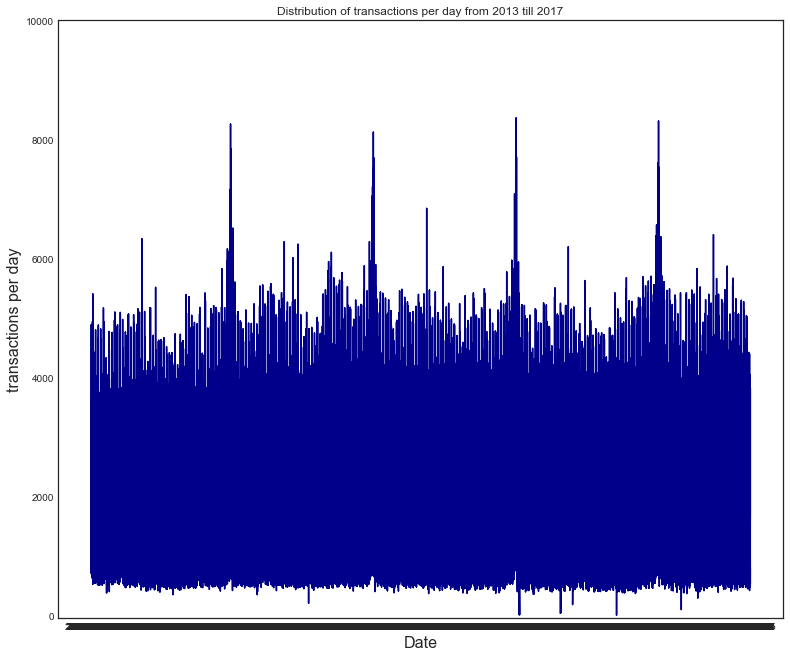

In [50]:
plt.style.use('seaborn-white')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

The bigger yearly periodic spike in transactions seem to occur at the end of the year in December. Perhaps this is due to some sort of Christmas sale/discount that Corporacion Favorita holds every December.

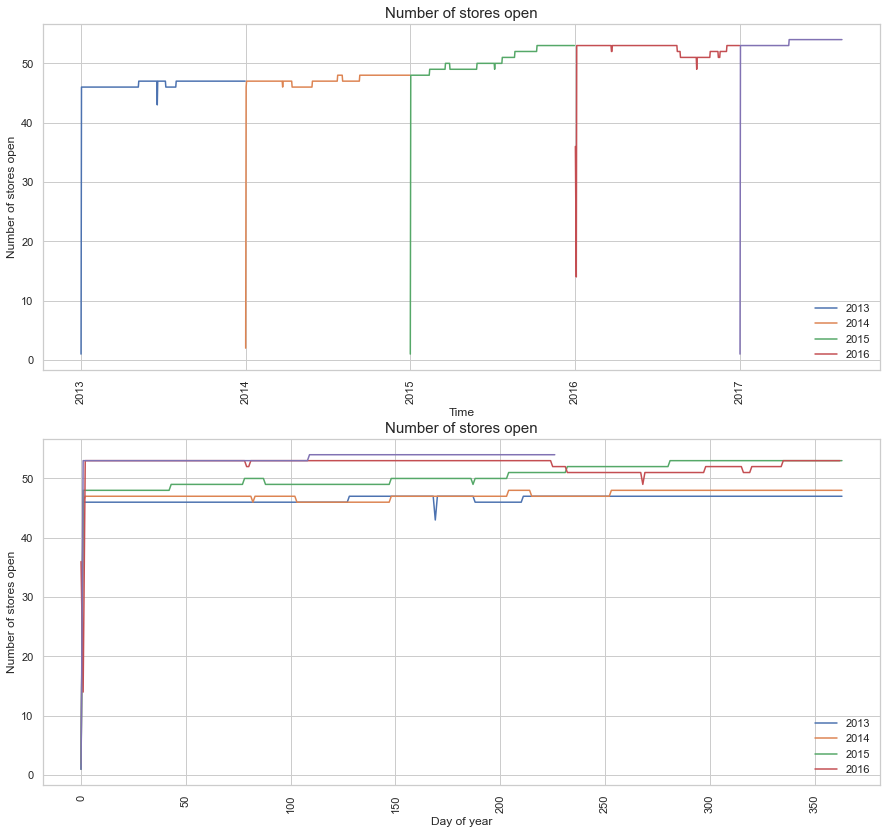

In [51]:
#transactions
# month over month sales
transactions['date']=pd.to_datetime(transactions['date'])
temp=transactions.groupby(['date']).aggregate({'store_nbr':'count','transactions':np.sum})
temp=temp.reset_index()
temp_2013=temp[temp['date'].dt.year==2013].reset_index(drop=True)
temp_2014=temp[temp['date'].dt.year==2014].reset_index(drop=True)
temp_2015=temp[temp['date'].dt.year==2015].reset_index(drop=True)
temp_2016=temp[temp['date'].dt.year==2016].reset_index(drop=True)
temp_2017=temp[temp['date'].dt.year==2017].reset_index(drop=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(15,14))
plt.subplot(211)
plt.plot(temp_2013['date'],temp_2013.iloc[:,1],label="2013")
plt.plot(temp_2014['date'],temp_2014.iloc[:,1],label="2014")
plt.plot(temp_2015['date'],temp_2015.iloc[:,1],label="2015")
plt.plot(temp_2016['date'],temp_2016.iloc[:,1],label="2016")
plt.plot(temp_2017['date'],temp_2017.iloc[:,1],label="2017")
plt.ylabel('Number of stores open', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Number of stores open', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='lower right')

plt.subplot(212)
plt.plot(temp_2013.index,temp_2013.iloc[:,1],label="2013")
plt.plot(temp_2014.index,temp_2014.iloc[:,1],label="2014")
plt.plot(temp_2015.index,temp_2015.iloc[:,1],label="2015")
plt.plot(temp_2016.index,temp_2016.iloc[:,1],label="2016")
plt.plot(temp_2017.index,temp_2017.iloc[:,1],label="2017")


plt.ylabel('Number of stores open', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
plt.title('Number of stores open', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='lower right')
plt.show()

There seems to be certain local holidays where some of the stores are closed. But there is no consistent pattern of holidays where stores are closed

### Store #47

The chain established itselft in Quito in 1952 (We knew this from Wikipedia), so let's pick a shop in Quito as a starting point, as the brand is well established there. Let us pick #47 and plot the corresponding transactions time series. With a well established store, we can predict that the time series will be almost stationary. High seasonality is expected too, as people consume more during celebration periods.

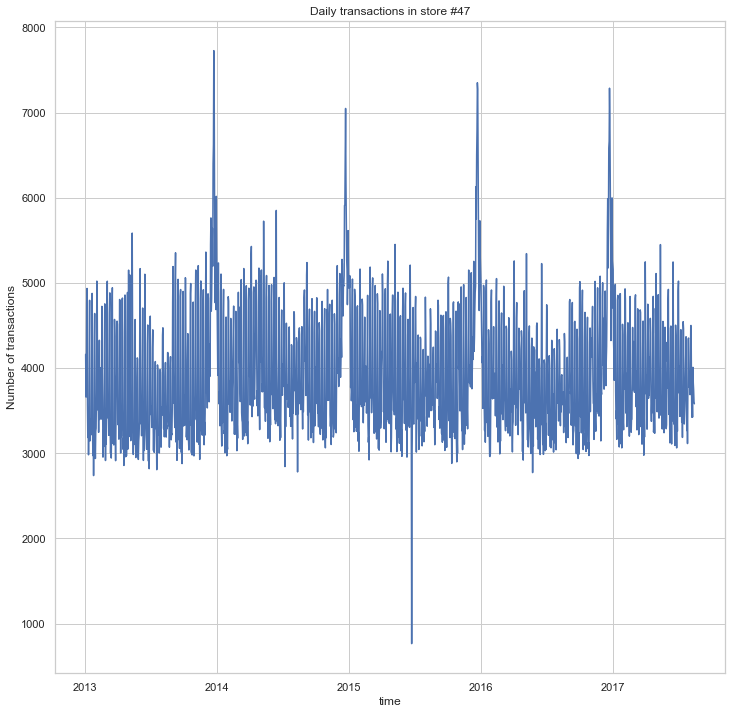

In [52]:
ts=transactions.loc[transactions['store_nbr']==47,['date','transactions']].set_index('date')
ts=ts.transactions.astype('float')
plt.figure(figsize=(12,12))
plt.title('Daily transactions in store #47')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

## 3.5 Items data

Item metadata, including family, class, and perishable.

In [53]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [54]:
items['perishable'].unique()

array([0, 1])

In [55]:
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                         items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
     width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

As we can see from the plot, the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories.

In [56]:
items['class'].nunique()

337

In [57]:
x, y = (list(x) for x in zip(*sorted(zip(items['class'].value_counts().index, 
                                         items['class'].value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    x=items['class'].value_counts().index,
    y=items['class'].value_counts().values,
    marker=dict(
        color=items['class'].value_counts().values,
        colorscale = 'Jet',
        reversescale = True
    ),
    orientation='v',
)

layout = dict(
    title='Number of items attributed to a particular item class',
     width = 800, height = 600,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

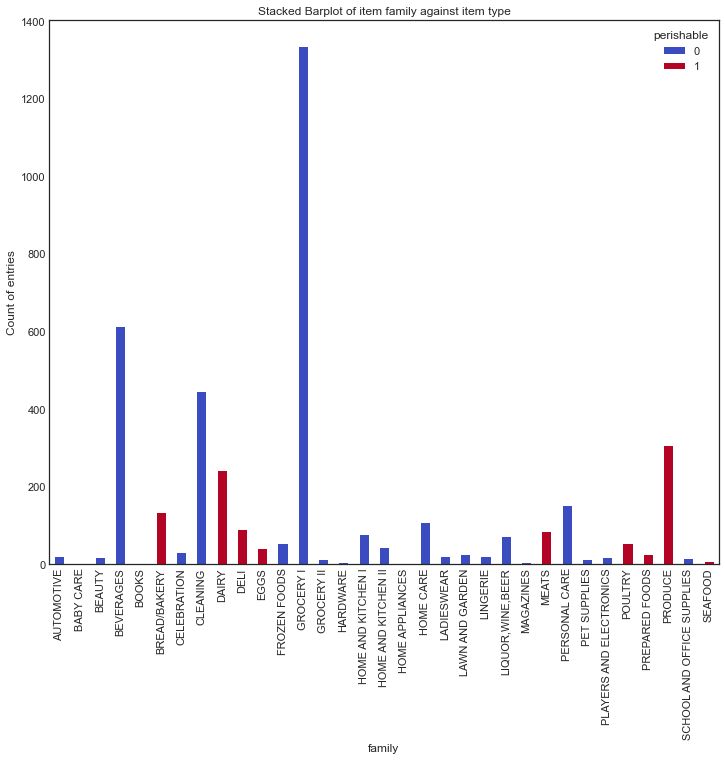

In [58]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of item family against item type')
plt.ylabel('Count of entries')
plt.show()

## 4.0 Machine Learning

In [59]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


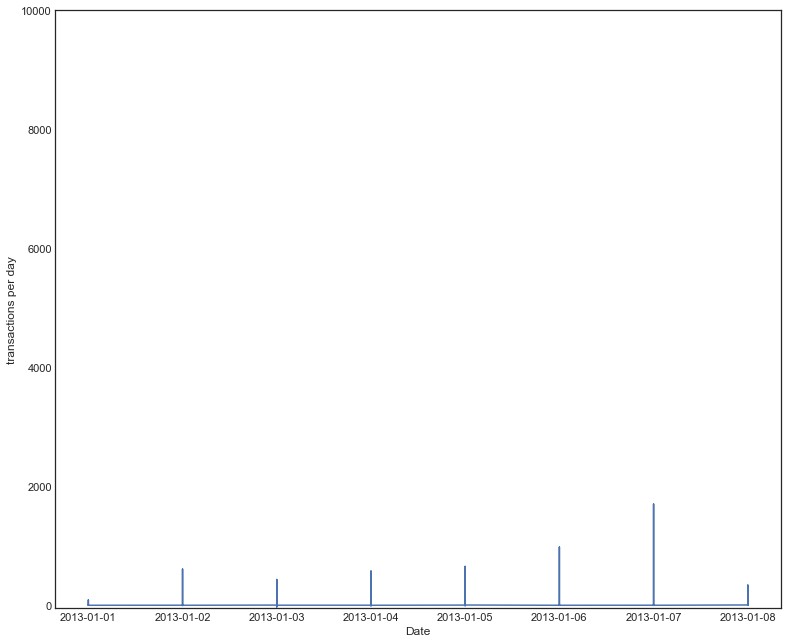

In [60]:
plt.style.use('seaborn-deep')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

## 4.1 Further Analysis

### 4.1.1 Store Distrubution

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:3

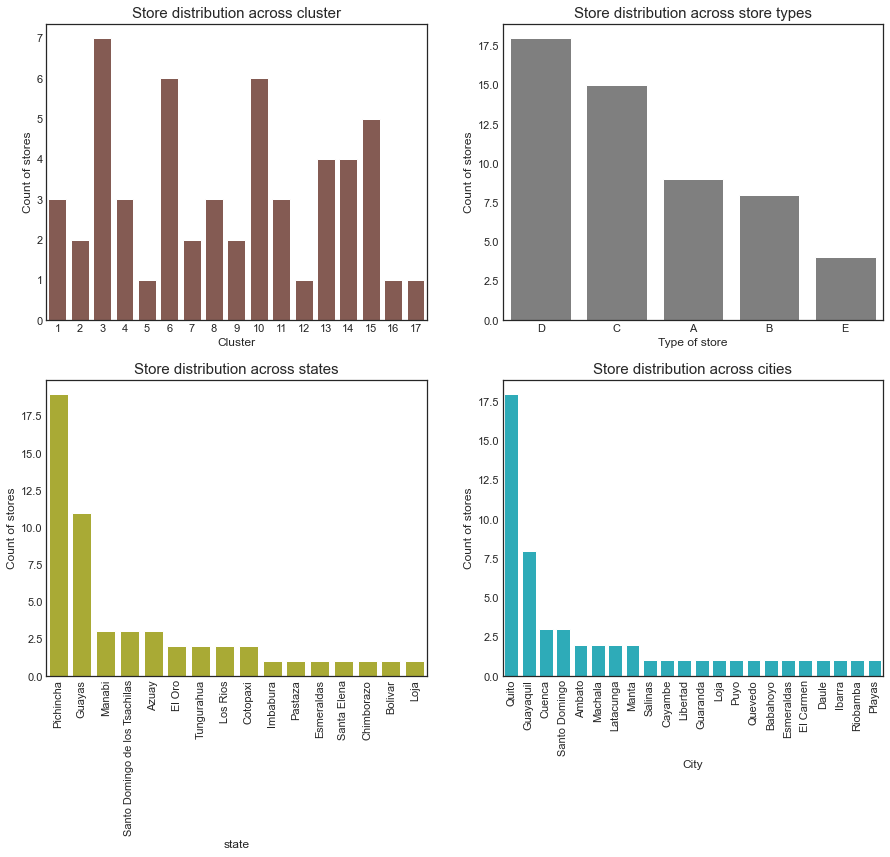

In [61]:
#Count of stores in different types and clusters
plt.figure(figsize=(15,12))
#row col plotnumber - 121
plt.subplot(221)
# Count of stores for each type 
temp = stores['cluster'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[5])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.title('Store distribution across cluster', fontsize=15)

plt.subplot(222)
# Count of stores for each type 
temp = stores['type'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[7])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Type of store', fontsize=12)
plt.title('Store distribution across store types', fontsize=15)

plt.subplot(223)
# Count of stores for each type 
temp = stores['state'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[8])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('state', fontsize=12)
plt.title('Store distribution across states', fontsize=15)
plt.xticks(rotation='vertical')

plt.subplot(224)
# Count of stores for each type 
temp = stores['city'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[9])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('Store distribution across cities', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### Sale distribution

### Sale variation

**Here we analyze the data and select the features for our model to be trained on.**

**Train**
id, date, store_nbr, item_nbr, unit_scale, on_promotion

**Holidays_events**
date, type, locale, locale_name, description, transferred

**Stores**
store_nbr, city, state, type, cluster

**Transactions**
date, store_nbr, transactions

**Items**
item_nbr, family, class, perishable

**Oil**
date, dcoilwtico

**Selected features as inputs to the model**

date, holiday.type, holidaye.locale, holiday.locale_name, holiday_transfered, store_nbr, store.city, store.state, store.type, store.cluster, transactions, item_nbr, item.family, item.class, on_promotion, perishable, dcoilwtico.

**Selected features as outputs of the model**

unit_sales per item, transactions per store

## 4.2 Data pipeline

In [62]:
train_large.dtypes

id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
dtype: object

In [63]:
train_large.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
79728076,87728075,2016-08-11,44,1584305,1.0,False
28804655,36804654,2014-12-06,53,1464258,1.0,False
70529780,78529779,2016-05-07,49,268443,27.0,False
45471536,53471535,2015-08-09,3,1038952,12.0,False
6661871,14661870,2013-11-28,44,1221054,1.0,NaN


In [64]:
train_large['date']

79728076    2016-08-11
28804655    2014-12-06
70529780    2016-05-07
45471536    2015-08-09
6661871     2013-11-28
               ...    
45139725    2015-08-05
57392383    2015-12-20
31069819    2015-01-10
91066685    2016-12-06
21070124    2014-08-14
Name: date, Length: 1000000, dtype: object

In [65]:
train_large.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
79728076,87728075,2016-08-11,44,1584305,1.0,False
28804655,36804654,2014-12-06,53,1464258,1.0,False
70529780,78529779,2016-05-07,49,268443,27.0,False
45471536,53471535,2015-08-09,3,1038952,12.0,False
6661871,14661870,2013-11-28,44,1221054,1.0,NaN


## 4.2 Add derived features

In [66]:
train_large['month'] = pd.DatetimeIndex(train_large['date']).month

In [67]:
train_large['month_'] = train_large['month'].apply(str)
train_large['month_'].head()

79728076     8
28804655    12
70529780     5
45471536     8
6661871     11
Name: month_, dtype: object

In [68]:
train_large['Day'] = pd.DatetimeIndex(train_large['date']).day_name()

In [69]:
train_large['Day'].unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Friday', 'Wednesday',
       'Tuesday'], dtype=object)

In [70]:
train_large['dayOfWeek'] = pd.DatetimeIndex(train_large['date']).weekday
train_large['dayOfWeek'] = train_large['dayOfWeek'].apply(str)
train_large['dayOfWeek'].head()

79728076    3
28804655    5
70529780    5
45471536    6
6661871     3
Name: dayOfWeek, dtype: object

In [71]:
train_large['dayOfWeek'].unique()

array(['3', '5', '6', '0', '4', '2', '1'], dtype=object)

In [72]:
train_large['dayOfYear'] = pd.DatetimeIndex(train_large['date']).dayofyear

In [73]:
train_large['dayOfYear'].unique()

array([224, 340, 128, 221, 332, 197, 196, 116, 320,  10,  55, 284,  90,
       113, 136, 121, 126, 103,  45, 315, 227, 177, 266,  39, 161, 274,
        76, 352,  63, 261, 184, 204, 361, 226, 346, 351, 299,  37, 210,
       317, 277, 199,  31, 251,  88, 318, 131, 260, 349, 169, 289,  87,
       247, 123, 212, 311, 356,  46, 282, 156, 262, 308, 122, 159,  35,
       350,  96, 237, 187, 157, 198, 127, 267, 275,   9, 272, 357, 347,
       290, 238,  66, 276, 345,  91, 344,   5,  86, 185, 194, 186, 151,
       339, 134,  42,  75, 280,  59,   7, 173,  28, 138, 250,  49, 120,
        14, 334, 209, 147, 202, 312,  72,  15, 230, 232, 341,  71, 149,
       291, 108, 205, 214, 162, 258,  65,  26,  82, 296, 189, 146, 279,
       246, 117, 175, 295, 171,  52, 223, 335, 107, 229,  21, 216, 158,
       203,  54, 255, 174,  97, 150, 182, 130, 153, 331,  64, 140, 288,
       269, 105, 215, 132, 323,  48, 271, 242, 191,  40, 327,  29, 225,
       257,  78, 239, 343, 241, 362, 303, 188,  47, 220, 306, 12

In [74]:
train_large['month_'].unique()

array(['8', '12', '5', '11', '7', '4', '1', '2', '10', '3', '6', '9'],
      dtype=object)

In [75]:
train_large['year'] = pd.DatetimeIndex(train_large['date']).year

In [76]:
train_large['year_'] = train_large['year'].apply(str)
train_large['year_'].head()

79728076    2016
28804655    2014
70529780    2016
45471536    2015
6661871     2013
Name: year_, dtype: object

In [77]:
train_large['year_'].unique()

array(['2016', '2014', '2015', '2013', '2017'], dtype=object)

### 4.2.2 Takes files in, outputs a complete dataframe

datetime.toordinal() is a simple method used to manipulate the objects of DateTime class. It returns proleptic Gregorian ordinal of the date, where January 1 of year 1 has ordinal 1. The function returns the ordinal value for the given DateTime object.

If January 1 of year 1 has ordinal number 1 then, January 2 year 1 will have ordinal number 2, and so on.

In [78]:
import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin

class prepare_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("prepare_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        train_stores = X[0].merge(X[1], how='left', right_on = 'store_nbr', left_on='store_nbr')
        train_stores_oil = train_stores.merge(X[2], how='left', right_on='date', left_on='date')
        train_stores_oil_items = train_stores_oil.merge(X[3], how='left', right_on = 'item_nbr', left_on = 'item_nbr')
        train_stores_oil_items_transactions = train_stores_oil_items.merge(X[4], right_on = ['date', 'store_nbr'], left_on = ['date', 'store_nbr'])
        train_stores_oil_items_hol = train_stores_oil_items.merge(X[5], how='left', right_on = 'date', left_on = 'date')
        
        data_df = train_stores_oil_items_hol.copy(deep = True)
        
        # change the bool to int
        data_df['onpromotion'] = data_df['onpromotion'].astype(float)
        data_df["transferred"].fillna(False,inplace=True)
        data_df['transferred'] = data_df['transferred'].astype(int)

        # change the names
        data_df.rename(columns={'type_x': 'st_type', 'type_y': 'hol_type'}, inplace=True)

        # drop the id
        data_df.drop(['id'], axis=1, inplace=True)
        
        print(data_df.head())
        
        # handle date
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df['date'] = data_df['date'].map(dt.datetime.toordinal)
        print("prepare_data data_df shape:",data_df.shape)
                
        return data_df

### Custom transform for splitting the data

In [79]:
# split dataframe into numerical values, categorical values and date
class split_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("split_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Get columns for each type         
        df_ = X.drop(['date'], axis = 1)
        cols = df_.columns
        num_cols = df_._get_numeric_data().columns
        cat_cols = list(set(cols) - set(num_cols))
        
        data_num_df = X[num_cols]
        data_cat_df = X[cat_cols]
        data_date_df = X['date']
        print("split_data data_num_df shape:",data_num_df.shape)
        print("split_data data_cat_df shape:",data_cat_df.shape)
        print("split_data data_date_df shape:",data_date_df.shape)
        
        return data_num_df, data_cat_df, data_date_df

### Custom transform

1. Fill missing data in numerical attributes
2. apply standard scaler to numerical attributes
3. Convert categorical data into numerical

Need of an imputer
A Few algorithms like Random Forest in sklearn does not automatically handle the missing values. The algorithm will return an error if it finds any NaN or Null values in your data

In [80]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

class process_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("process_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        # impute nulls in numerical attributes
        imputer = SimpleImputer(strategy="mean", copy="true")
        num_imp = imputer.fit_transform(X[0])
        data_num_df = pd.DataFrame(num_imp, columns=X[0].columns, index=X[0].index)
        
        ### categorical data
        # impute missing data with 'NA' values
        imputer_cat = SimpleImputer(strategy="constant", fill_value="NA", copy="true")
        cat_imp = imputer_cat.fit_transform(X[1])
        
        # one hot encoder
        cat_encoder = OneHotEncoder(sparse=False)
        data_cat_1hot = cat_encoder.fit_transform(cat_imp)
        
        # convert it to datafram with n*99 where n number of rows and 99 is no. of categories
        data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_encoder.get_feature_names()) #, index=X[1].index)
                
        return data_num_df, data_cat_df, X[2]

### yet another transform

In [81]:
class join_df(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("join_df -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        data_df = X[0].join(X[1])
        data_df = data_df.join(X[2])
        
        return data_df

In [82]:
transactions_df['date'].dtypes

dtype('O')

In [84]:
train_large['date'].dtypes

dtype('O')

In [85]:
train_large.shape

(1000000, 13)

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipe_processing = Pipeline([
        ('prepare_data', prepare_data()),
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

# our prepared data
data_df = pipe_processing.fit_transform([train_large, stores, oil, items, transactions_df, holiday_events])



prepare_data -> init
split_data -> init
process_data -> init
join_df -> init
         date  store_nbr  item_nbr  unit_sales  onpromotion  month month_  \
0  2016-08-11         44   1584305         1.0          0.0      8      8   
1  2014-12-06         53   1464258         1.0          0.0     12     12   
2  2016-05-07         49    268443        27.0          0.0      5      5   
3  2016-05-07         49    268443        27.0          0.0      5      5   
4  2015-08-09          3   1038952        12.0          0.0      8      8   

        Day dayOfWeek  dayOfYear  ...  cluster dcoilwtico        family class  \
0  Thursday         3        224  ...        5      43.51    LADIESWEAR  7780   
1  Saturday         5        340  ...       13        NaN     BEVERAGES  1114   
2  Saturday         5        128  ...       11        NaN      CLEANING  3026   
3  Saturday         5        128  ...       11        NaN      CLEANING  3026   
4    Sunday         6        221  ...        8        N

In [87]:
data_df.tail()

,store_nbr,item_nbr,unit_sales,onpromotion,month,dayOfYear,year,cluster,dcoilwtico,class,...,x11_Machala,x11_Manta,x11_Playas,x11_Puyo,x11_Quevedo,x11_Quito,x11_Riobamba,x11_Salinas,x11_Santo Domingo,date
1019393,1.0,1673297.0,3.0,1.0,8.0,217.0,2015.0,13.0,45.130000,2018.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,735815
1019394,3.0,1464081.0,15.0,0.0,12.0,354.0,2015.0,8.0,59.173381,1190.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,735952
1019395,2.0,679604.0,5.0,0.0,1.0,10.0,2015.0,13.0,59.173381,2712.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,735608
1019396,10.0,1977997.0,1.0,0.0,12.0,341.0,2016.0,15.0,50.950000,2170.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736304
1019397,50.0,1243815.0,3.0,0.0,8.0,226.0,2014.0,14.0,95.540000,1122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735459


In [88]:
data_df['onpromotion'].value_counts()

0.000000    834333
0.075765    116670
1.000000     68395
Name: onpromotion, dtype: int64

##  5.1 POST REVIEW #1

Adds derived column representing the most recently unit_sales from a given store.
It is recommended to use numerical features for month,dayOfWeek,month etc. Using categorical features essentially means that you don't consider distance between two categories as relevant (e.g. category 1 is as close to category 2 as it is to category 3). This is definitely not the case for hours,dates etc

In [89]:
store_nbr_=data_df['store_nbr'].unique()
store_nbr_

array([44., 53., 49.,  3., 20.,  1., 47., 50.,  4., 30., 51., 24.,  8.,
        2., 40., 38., 34., 14., 23., 41., 32., 16.,  9., 27., 43., 21.,
        6., 19., 54., 35., 29., 45., 31., 12., 18., 46., 11., 37., 28.,
       15., 22., 26., 42., 10., 39., 33.,  5.,  7., 17., 13., 52., 48.,
       25., 36.])

In [90]:
dates_=data_df['date'].unique()
# dates_

In [91]:
months_=data_df['month'].unique()
months_

array([ 8., 12.,  5., 11.,  7.,  4.,  1.,  2., 10.,  3.,  6.,  9.])

In [92]:
years_=data_df['year'].unique()
years_

array([2016., 2014., 2015., 2013., 2017.])

In [93]:
years_.sort()

In [94]:
months_.sort()

In [95]:
data_df.head()

,store_nbr,item_nbr,unit_sales,onpromotion,month,dayOfYear,year,cluster,dcoilwtico,class,...,x11_Machala,x11_Manta,x11_Playas,x11_Puyo,x11_Quevedo,x11_Quito,x11_Riobamba,x11_Salinas,x11_Santo Domingo,date
0,44.0,1584305.0,1.0,0.0,8.0,224.0,2016.0,5.0,43.510000,7780.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736187
1,53.0,1464258.0,1.0,0.0,12.0,340.0,2014.0,13.0,59.173381,1114.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735573
2,49.0,268443.0,27.0,0.0,5.0,128.0,2016.0,11.0,59.173381,3026.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736091
3,49.0,268443.0,27.0,0.0,5.0,128.0,2016.0,11.0,59.173381,3026.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736091
4,3.0,1038952.0,12.0,0.0,8.0,221.0,2015.0,8.0,59.173381,2714.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,735819


In [96]:
for col in data_df.columns:
    print(col)

store_nbr
item_nbr
unit_sales
onpromotion
month
dayOfYear
year
cluster
dcoilwtico
class
perishable
transferred
x0_1
x0_10
x0_11
x0_12
x0_2
x0_3
x0_4
x0_5
x0_6
x0_7
x0_8
x0_9
x1_AUTOMOTIVE
x1_BABY CARE
x1_BEAUTY
x1_BEVERAGES
x1_BOOKS
x1_BREAD/BAKERY
x1_CELEBRATION
x1_CLEANING
x1_DAIRY
x1_DELI
x1_EGGS
x1_FROZEN FOODS
x1_GROCERY I
x1_GROCERY II
x1_HARDWARE
x1_HOME AND KITCHEN I
x1_HOME AND KITCHEN II
x1_HOME APPLIANCES
x1_HOME CARE
x1_LADIESWEAR
x1_LAWN AND GARDEN
x1_LINGERIE
x1_LIQUOR,WINE,BEER
x1_MAGAZINES
x1_MEATS
x1_PERSONAL CARE
x1_PET SUPPLIES
x1_PLAYERS AND ELECTRONICS
x1_POULTRY
x1_PREPARED FOODS
x1_PRODUCE
x1_SCHOOL AND OFFICE SUPPLIES
x1_SEAFOOD
x2_Local
x2_NA
x2_National
x2_Regional
x3_0
x3_1
x3_2
x3_3
x3_4
x3_5
x3_6
x4_Additional
x4_Bridge
x4_Event
x4_Holiday
x4_NA
x4_Transfer
x4_Work Day
x5_2013
x5_2014
x5_2015
x5_2016
x5_2017
x6_A
x6_B
x6_C
x6_D
x6_E
x7_Azuay
x7_Bolivar
x7_Chimborazo
x7_Cotopaxi
x7_El Oro
x7_Esmeraldas
x7_Guayas
x7_Imbabura
x7_Loja
x7_Los Rios
x7_Manabi
x7_P

In [97]:
# dates_

In [98]:
store_nbr_

array([44., 53., 49.,  3., 20.,  1., 47., 50.,  4., 30., 51., 24.,  8.,
        2., 40., 38., 34., 14., 23., 41., 32., 16.,  9., 27., 43., 21.,
        6., 19., 54., 35., 29., 45., 31., 12., 18., 46., 11., 37., 28.,
       15., 22., 26., 42., 10., 39., 33.,  5.,  7., 17., 13., 52., 48.,
       25., 36.])

## 5.2 Optimize calculation of 'last_month_sales' derived column

Instead of calculating last_month_sales run time, we make use of pre-computed information in dictionary named 'arr'

In [99]:
def last_month_sales_of_a_given_store(data_df, year, month, store_nbr):
        new_df = data_df.loc[(data_df['year'] == year) & (data_df['month'] == month) & (data_df['store_nbr'] == store_nbr)]
        if new_df.empty:
            new_df = data_df.loc[(data_df['month'] == month) & (data_df['year'] == year)]
            if new_df.empty:
                new_df = data_df.loc[(data_df['year'] == year)]
                
        mean_= new_df['unit_sales'].mean()
        return mean_

In [100]:
arr={}
for k in range(len(years_)):
    for i in range(len(months_)):
        for j in store_nbr_:
            if k == 0 and i == 0:
                arr[(years_[k],months_[i],j)] = last_month_sales_of_a_given_store(data_df,years_[k],months_[i],j)
            elif i == 0:
                arr[(years_[k],months_[i],j)] = last_month_sales_of_a_given_store(data_df,years_[k]-1,12.0,j)
            else:
                arr[(years_[k],months_[i],j)] = last_month_sales_of_a_given_store(data_df,years_[k],months_[i]-1,j)

'arr' is dictionary type with key type as tuple of format (a,b,c) where a is year,b is cardinal value of month and
being the store_num. each key has a value of average unit sales over last month period.
The dictionary 'arr' maps the average last month sales for a given store and month.

In [102]:
len(arr)

3240

### 5.2.1 Adding 'last_month_sales' column

In [103]:
for k in range(len(years_)):
    for i in range(len(months_)):
        for j in store_nbr_:
            data_df.loc[(data_df['year'] == years_[k]) & (data_df['month'] == months_[i]) & (data_df['store_nbr'] == j), 'last_month_sales'] = arr[(years_[k],months_[i],j)] 

In [105]:
data_df['last_month_sales'].nunique()

2477

In [106]:
data_df['last_month_sales'].tail()

1019393     6.019057
1019394    14.408436
1019395     7.955362
1019396     4.870285
1019397     8.556115
Name: last_month_sales, dtype: float64

In [107]:
data_df['unit_sales'].lt(0).sum()

67

In [108]:
data_df[data_df['unit_sales']<0] = 0

In [109]:
data_df['unit_sales'].lt(0).sum()

0

In [110]:
nan_values = data_df.isna()
nan_columns = nan_values.any()
columns_with_nan = data_df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [111]:
# split it according to our feature engineering
X = data_df.drop(['unit_sales'], axis=1)
Y = data_df[['unit_sales']]

##  6.1 POST REVIEW #2

- Tried LGBMRegressor 
- Temporal split on train/validation - already done
- Evaluate with the same metric
- Last month - with random sampling - empty spaces. 2 months for only 1-5 stores: would make last months sales powerful but lose power store id (and related features) not mandatory, more like an option
- Validation set as close as possible to test set (wishful thinking)
- Temporal - limit last 3 months and sample from that (last month = validation)
- scikit pipeline for preprocessing (Combining test and train data with a special column with origin test/train and/or sklearn.Pipeline to create same features.)
- High cardinality features:
    - Target mean encoding (average number of sales for a particular item, bayesian smoothing) - avoid target leaking through cross-validation
    - lighgbm
    - Online-learning algorithm: vowpal-wabbit

## 7.1 TrainTestSplit


In [112]:
X = X.reindex(sorted(X.columns), axis=1)

In [113]:
#data split by preserving time-series pattern
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [114]:
for col in X.columns:
    print(col)

class
cluster
date
dayOfYear
dcoilwtico
item_nbr
last_month_sales
month
onpromotion
perishable
store_nbr
transferred
x0_1
x0_10
x0_11
x0_12
x0_2
x0_3
x0_4
x0_5
x0_6
x0_7
x0_8
x0_9
x10_Batalla de Pichincha
x10_Black Friday
x10_Cantonizacion de Cayambe
x10_Cantonizacion de El Carmen
x10_Cantonizacion de Guaranda
x10_Cantonizacion de Latacunga
x10_Cantonizacion de Libertad
x10_Cantonizacion de Quevedo
x10_Cantonizacion de Riobamba
x10_Cantonizacion de Salinas
x10_Cantonizacion del Puyo
x10_Carnaval
x10_Cyber Monday
x10_Dia de Difuntos
x10_Dia de la Madre
x10_Dia de la Madre-1
x10_Dia del Trabajo
x10_Fundacion de Ambato
x10_Fundacion de Cuenca
x10_Fundacion de Esmeraldas
x10_Fundacion de Guayaquil
x10_Fundacion de Guayaquil-1
x10_Fundacion de Ibarra
x10_Fundacion de Loja
x10_Fundacion de Machala
x10_Fundacion de Manta
x10_Fundacion de Quito
x10_Fundacion de Quito-1
x10_Fundacion de Riobamba
x10_Fundacion de Santo Domingo
x10_Inauguracion Mundial de futbol Brasil
x10_Independencia de Ambato

In [115]:
len(X['date'])

1019398

In [117]:
x_test.head()

,class,cluster,date,dayOfYear,dcoilwtico,item_nbr,last_month_sales,month,onpromotion,perishable,...,x8_Santo Domingo,x8_Santo Domingo de los Tsachilas,x9_Friday,x9_Monday,x9_Saturday,x9_Sunday,x9_Thursday,x9_Tuesday,x9_Wednesday,year
713578,4130.0,11.0,735521,288.0,81.820000,1230416.0,13.455634,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2014.0
713579,1114.0,10.0,736477,148.0,59.173381,1466047.0,7.237762,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017.0
713580,2016.0,3.0,736158,195.0,44.870000,1695991.0,3.852409,7.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016.0
713581,1060.0,3.0,735333,100.0,103.370000,804974.0,11.048688,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014.0
713582,1124.0,13.0,735486,253.0,91.710000,315178.0,7.710334,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2014.0


## 8.1 Modelling and testing

### Generic function for modelling and testing

In [118]:
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


def checkModelPerformane(model):
    model.fit(x_train.values, y_train.values)
    pred = model.predict(x_test.values)
#     print("predictions",pred[:5])
    print("mean_squared_error: ",np.sqrt(mean_squared_error(y_test.values, pred))) 
    print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_test.values, pred)))
    weights2=[]
    weight2 = x_test.loc[:,'perishable']
    for z in weight2:
        if z == 0.0:
            weights2.append(1)
        else:
            weights2.append(1.25)
    y = y_test['unit_sales'].tolist()  
    
    print("pred :", pred)
    if type(model) == linear_model._base.LinearRegression or type(model) == linear_model._ridge.Ridge:
        pred = [item for sublist in pred for item in sublist]
    flat_list_pred = [0 if x < 0 else x for x in pred]
    flat_list_pred = [x+1 for x in flat_list_pred]
    y = [x+1 for x in y]
#     print("weights2 :", weights2)
#     print("pred :", flat_list_pred)
#     print("y :", y)
#     print("weights2 shape:", len(weights2))
#     print("pred shape:", len(flat_list_pred))
#     print("y shape:", len(y))
    pred = [x+1 for x in pred]
    y = [x+1 for x in y]
    score = (sum((weights2*(np.log(flat_list_pred) - np.log(y)))**2) / (sum(weights2)))**0.5
    print("Evalauation metric: ",score)

In [119]:
Y.tail()

,unit_sales
1019393,3.0
1019394,15.0
1019395,5.0
1019396,1.0
1019397,3.0


### Linear regression

In [120]:
type(LinearRegression())

sklearn.linear_model._base.LinearRegression

In [121]:
print("LinearRegression")
checkModelPerformane(LinearRegression())

LinearRegression
predictions [[ 9.51404502]
 [12.62072772]
 [11.8911423 ]
 [ 6.50286196]
 [12.27420755]]
mean_squared_error:  18.97897047027904
mean_absolute_error:  2.7130422113907966
pred : [[ 9.51404502]
 [12.62072772]
 [11.8911423 ]
 ...
 [ 9.15833304]
 [ 1.51318183]
 [11.60290086]]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.8407807828016999


In [122]:
type(linear_model.Lasso(alpha=0.1)) == linear_model._coordinate_descent.Lasso

True

### Lasso regression

In [123]:
print("lasso regression ")
checkModelPerformane(linear_model.Lasso(alpha=0.1))

lasso regression 
predictions [ 9.38913677 11.85859624 11.44301656  8.12833751 11.52322598]
mean_squared_error:  19.05199967684281
mean_absolute_error:  2.705778361512239
pred : [ 9.38913677 11.85859624 11.44301656 ...  8.10233117  5.54366178
 11.94058238]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.8100596519874337


### ElasticNet regression

In [124]:
print("ElasticNet regression ")
checkModelPerformane(ElasticNet())

ElasticNet regression 
predictions [10.14746231  9.50567765  6.80209387 11.20659177  8.20654131]
mean_squared_error:  19.32717228276843
mean_absolute_error:  2.744836064720853
pred : [10.14746231  9.50567765  6.80209387 ...  6.07167337  7.423179
 11.05930926]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.8185841185279341


### Ridge regression

In [125]:
type(Ridge(alpha=1.0))

sklearn.linear_model._ridge.Ridge

In [126]:
print("Ridge regression ")
checkModelPerformane(Ridge(alpha=1.0))

Ridge regression 


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=4.83017e-18): result may not be accurate.



predictions [[ 9.51442735]
 [12.61673661]
 [11.89100044]
 [ 6.50679244]
 [12.27270907]]
mean_squared_error:  18.97896197337135
mean_absolute_error:  2.713036103768962
pred : [[ 9.51442735]
 [12.61673661]
 [11.89100044]
 ...
 [ 9.16063696]
 [ 1.51890856]
 [11.60059568]]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.8407674674269632


In [127]:
type(Ridge(alpha=1.0))

sklearn.linear_model._ridge.Ridge

### Random forests

In [128]:
print("Random Forest")
forest_reg1 = RandomForestRegressor(random_state=42)
checkModelPerformane(forest_reg1) 

Random Forest


<ipython-input-118-934aee85cfa5>:11: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



predictions [ 1.76     5.68     4.38731  5.34    13.38   ]
mean_squared_error:  19.148724532306034
mean_absolute_error:  2.3644800438402775
pred : [1.76    5.68    4.38731 ... 4.61    2.69    4.07   ]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.6285899036210377


What is random about random forest regression?

The ensemble of decision trees has high accuracy because it uses randomness on two levels:

  The algorithm randomly selects a subset of features, which can be used as candidates at each split. This prevents the multitude of decision trees from relying on the same set of features and decorrelates individual trees.
    Each tree draws a random sample of data from the training dataset when generating its splits. This introduces a further element of randomness, which prevents the individual trees from overfitting the data. Since they cannot see all of the data, they cannot overfit it.

Ensembling decision trees allows us to compensate for the weaknesses of each individual tree.

Random forest model has the lowest error, thus we are going to use it and fine tune it.

### LGBMRegressor

In [129]:
import lightgbm as lgb
model = lgb.LGBMRegressor()
checkModelPerformane(model) 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



predictions [ 4.03931704  7.38863529  6.50734572  7.17355157 10.4049253 ]
mean_squared_error:  18.82336991323112
mean_absolute_error:  2.5761481466410667
pred : [4.03931704 7.38863529 6.50734572 ... 7.40095987 3.96750927 8.80858188]
weights2 shape: 305820
pred shape: 305820
y shape: 305820
Evalauation metric:  0.7209124443761791


## 9.1 Model fine tuning

### 9.1.1 GridSearchCV based hyper parameter tuning on dynamically chosen best algorithm approach

### Grid search

In [131]:
from sklearn import metrics
def custom_score(X_train_scaled, Y_train_scaled):
    y = X_train_scaled
    pred = Y_train_scaled
    return metrics.mean_squared_error(y, pred)**0.5

In [132]:
y_train.shape

(713578, 1)

In [134]:
from sklearn.metrics.scorer import make_scorer
custom_scorer = make_scorer(custom_score, greater_is_better=True)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [135]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 100], 'max_features': [2, 4, 6, 8], 'min_samples_leaf': [1, 2]}]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring=custom_scorer, return_train_score=True)
grid_search.fit(x_train.values, y_train.values)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/pytho

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/anaconda3/lib/pytho

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'min_samples_leaf': [1, 2],
                          'n_estimators': [30, 100]}],
             return_train_score=True, scoring=make_scorer(custom_score))

In [137]:
forest_reg2=grid_search.best_estimator_

In [138]:
x_train.describe()

,class,cluster,date,dayOfYear,dcoilwtico,item_nbr,last_month_sales,month,onpromotion,perishable,...,x8_Santo Domingo,x8_Santo Domingo de los Tsachilas,x9_Friday,x9_Monday,x9_Saturday,x9_Sunday,x9_Thursday,x9_Tuesday,x9_Wednesday,year
count,713578.000000,713578.000000,713578.000000,713578.000000,713578.000000,7.135780e+05,713578.000000,713578.000000,713578.000000,713578.000000,...,713578.000000,713578.000000,713578.000000,713578.000000,713578.00000,713578.000000,713578.000000,713578.000000,713578.000000,713578.000000
mean,1967.915943,8.732224,735863.093568,183.269460,59.155471,9.963588e+05,8.597934,6.529866,0.075953,0.254658,...,0.003075,0.002622,0.138499,0.142502,0.15266,0.152569,0.136797,0.139060,0.137836,2015.223648
std,1157.921954,4.615891,6473.901809,103.694065,18.741553,5.239993e+05,4.131380,3.393599,0.249384,0.435669,...,0.055364,0.051138,0.345423,0.349564,0.35966,0.359572,0.343633,0.346009,0.344728,17.733518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1056.000000,5.000000,735585.000000,95.000000,47.240000,5.596820e+05,6.103219,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2014.000000
50%,1190.000000,9.000000,735971.000000,184.000000,59.173381,1.017349e+06,7.623388,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2016.000000
75%,2712.000000,13.000000,736275.000000,271.000000,59.173381,1.399750e+06,10.044707,9.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2016.000000
max,7780.000000,17.000000,736556.000000,366.000000,110.620000,2.127114e+06,126.455766,12.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,2017.000000


In [139]:
li=[0,1,2]
X.loc[X.index[li]]

,class,cluster,date,dayOfYear,dcoilwtico,item_nbr,last_month_sales,month,onpromotion,perishable,...,x8_Santo Domingo,x8_Santo Domingo de los Tsachilas,x9_Friday,x9_Monday,x9_Saturday,x9_Sunday,x9_Thursday,x9_Tuesday,x9_Wednesday,year
0,7780.0,5.0,736187,224.0,43.510000,1584305.0,15.510289,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016.0
1,1114.0,13.0,735573,340.0,59.173381,1464258.0,4.552283,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2014.0
2,3026.0,11.0,736091,128.0,59.173381,268443.0,13.833685,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016.0


In [145]:
test_index = [1,2]
Y.loc[Y.index[test_index]]['unit_sales']

1     1.0
2    27.0
Name: unit_sales, dtype: float64

### 9.1.2 TimeSeriesSplit based approach

In [144]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

In [146]:
final_score =10
sum_score = 0

forest_reg3 = RandomForestRegressor(random_state=42)

In [147]:
for train_index, test_index in tscv.split(X):
    X_train2, X_test2 = X.loc[X.index[train_index]], X.loc[X.index[test_index]]
    y_train2, y_test2 = Y.loc[Y.index[train_index]], Y.loc[Y.index[test_index]]
    forest_reg3.fit(X_train2.values, y_train2.values)
    pred = forest_reg3.predict(X_test2.values)
    
    weights2=[]
    weight2 = X_test2.loc[:,'perishable']
    for z in weight2:
        if z == 0.0:
            weights2.append(1)
        else:
            weights2.append(1.25)
    y = y_test2['unit_sales'].tolist()      
#     print("weights2 shape:", len(weights2))
#     print("pred shape:", len(pred))
#     print("y shape:", len(y))
    pred = [0 if x<0  else x for x in pred]
    pred = [x+1 for x in pred]
    y = [x+1 for x in y]
    score = (sum((weights2*(np.log(pred) - np.log(y)))**2) / (sum(weights2)))**0.5
    print("Score:", score)
    sum_score+= score
    if score < final_score:
        print("Best final_score", final_score)
        final_score = score
        
print("Best Average final_score from all splits", sum_score/3.0)

<ipython-input-147-1d99cad21137>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



weights2 shape: 169899
pred shape: 169899
y shape: 169899
Score: 0.8593789551460999
Best final_score 10


<ipython-input-147-1d99cad21137>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



weights2 shape: 169899
pred shape: 169899
y shape: 169899
Score: 0.8191477008898833
Best final_score 0.8593789551460999


<ipython-input-147-1d99cad21137>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



weights2 shape: 169899
pred shape: 169899
y shape: 169899
Score: 0.7855254759527251
Best final_score 0.8191477008898833


<ipython-input-147-1d99cad21137>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



weights2 shape: 169899
pred shape: 169899
y shape: 169899
Score: 0.7681356704978944
Best final_score 0.7855254759527251


<ipython-input-147-1d99cad21137>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



weights2 shape: 169899
pred shape: 169899
y shape: 169899
Score: 0.7533369740758072
Best final_score 0.7681356704978944
Best Average final_score from all splits 1.3285082588541366


## 10.1 Evaluate models from above two approaches on test set

Reference: https://scikit-learn.org/stable/modules/model_evaluation.html

Testing

When you have your model trained and tuned, it is time to test its final performance. Random Forest is just another Regression algorithm, so you can use all the regression metrics to assess its result.

For example, you might use MAE, MSE, MASE, RMSE, MAPE, SMAPE, and others. However, from my experience, MAE and MSE are the most commonly used. Both of them will be a good fit to evaluate the model’s performance. So, if you use them, keep in mind that the less is your error, the better and the error of the perfect model will be equal to zero.

Also, it is worth mentioning that you might not want to use any Cross-Validation technique to check the model’s ability to generalize. Some Data Scientists think that the Random Forest algorithm provides free Cross-Validation. You see, Random Forest randomizes the feature selection during each tree split, so that it does not overfit like other models. That is why using Cross-Validation on the Random Forest model might be unnecessary.

Still, if you want to use the Cross-Validation technique you can use the hold-out set concept. As mentioned before, samples from the original dataset that did not appear in any subset are called “out-of-bag” samples. They are a perfect fit for the hold-out set. Generally, using “out-of-bag” samples as a hold-out set will be enough for you to understand if your model generalizes well.

In sklearn, you can easily perform that using an oob_score = True parameter. If set to True, this parameter makes Random Forest Regressor use “out-of-bag” samples to estimate the R^2 on unseen data. If you get a value of more than 0.75, it means your model does not overfit (the best possible score is equal to 1)

In [150]:
x_test.shape

(305820, 256)

In [151]:
y_test.shape

(305820, 1)

In [152]:
forest_reg2.fit(x_train.values, y_train.values)
forest_reg3.fit(x_train.values, y_train.values)

<ipython-input-152-a2e86ecb0331>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-152-a2e86ecb0331>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=42)

In [153]:
final_predictions = forest_reg2.predict(x_test)
final_predictions3 = forest_reg3.predict(x_test)

In [154]:
final_predictions.shape

(305820,)

In [155]:
final_predictions3.shape

(305820,)

In [156]:
print("mean_squared_error: ",np.sqrt(mean_squared_error(y_test.values, final_predictions))) 
print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_test.values, final_predictions)))

mean_squared_error:  20.071793341049403
mean_absolute_error:  2.7261690780484535


In [157]:
final_predictions[:5]
#This corresponds to unit sales

array([ 3.46666667,  9.73333333,  2.6488    , 11.93333333,  6.13333333])

The coefficient of determination (r²) is a common regression metric. This value is typically between 0 and 1. It represents the percent of the variance of the target that the features contribute. Higher values are better, but in general it is difficult to evaluate the model from this metric alone.Does a .7 mean it is a good score? It depends. For a given dataset, .5 might be a good score, while for another dataset, a .9 may be a bad score. Typically we use this number in combination with other metrics or visualizations to evaluate a model.

## 11.1 Visualizing results

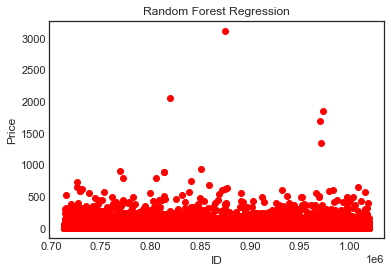

In [159]:
plt.scatter(x_test.index.values, y_test['unit_sales'].values, color = 'red')
plt.title('Random Forest Regression')
plt.xlabel('ID')
plt.ylabel('Price')
plt.show() 

Random Forest Regressor should not be used if the problem requires identifying any sort of trend

## 12.1 Submission of kaggle results on given dataset

### 12.2 Read actual test dataset

In [8]:
test_final = pd.read_csv("./input/test.csv")
test_final['date'].unique()

array(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
       '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
       '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype=object)

In [160]:
test_final.shape

(3370464, 5)

In [161]:
test_final.dtypes

id              int64
date           object
store_nbr       int64
item_nbr        int64
onpromotion      bool
dtype: object

In [162]:
test_final['date'].unique()

array(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
       '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
       '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype=object)

In [163]:
test_final['date'].nunique()

16

### 12.3 Construct derived features

In [164]:
test_final['month'] = pd.DatetimeIndex(test_final['date']).month
test_final['month_'] = test_final['month'].apply(str)
test_final['month_'].head()

0    8
1    8
2    8
3    8
4    8
Name: month_, dtype: object

In [165]:
test_final['year'] = pd.DatetimeIndex(test_final['date']).year
test_final['year_'] = test_final['year'].apply(str)
test_final['year_'].head()

0    2017
1    2017
2    2017
3    2017
4    2017
Name: year_, dtype: object

In [166]:
test_final['Day'] = pd.DatetimeIndex(test_final['date']).day_name()

In [167]:
test_final['dayOfWeek'] = pd.DatetimeIndex(test_final['date']).weekday
test_final['dayOfWeek'] = test_final['dayOfWeek'].apply(str)
test_final['dayOfWeek'].head()

0    2
1    2
2    2
3    2
4    2
Name: dayOfWeek, dtype: object

In [168]:
test_final['dayOfYear'] = pd.DatetimeIndex(test_final['date']).dayofyear

In [169]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipe_processing = Pipeline([
        ('prepare_data', prepare_data()),
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])


prepare_data -> init
split_data -> init
process_data -> init
join_df -> init


In [170]:
test_final_df = pipe_processing.fit_transform([test_final, stores, oil, items, transactions_df, holiday_events])

         date  store_nbr  item_nbr  onpromotion  month month_  year year_  \
0  2017-08-16          1     96995          0.0      8      8  2017  2017   
1  2017-08-16          1     99197          0.0      8      8  2017  2017   
2  2017-08-16          1    103501          0.0      8      8  2017  2017   
3  2017-08-16          1    103520          0.0      8      8  2017  2017   
4  2017-08-16          1    103665          0.0      8      8  2017  2017   

         Day dayOfWeek  ...  cluster dcoilwtico        family class  \
0  Wednesday         2  ...       13       46.8     GROCERY I  1093   
1  Wednesday         2  ...       13       46.8     GROCERY I  1067   
2  Wednesday         2  ...       13       46.8      CLEANING  3008   
3  Wednesday         2  ...       13       46.8     GROCERY I  1028   
4  Wednesday         2  ...       13       46.8  BREAD/BAKERY  2712   

   perishable  hol_type locale  locale_name  description transferred  
0           0       NaN    NaN         

In [171]:
test_months_=test_final_df['month'].unique()
test_months_

array([8.])

In [172]:
test_months_.sort()

In [173]:
test_years_=test_final_df['year'].unique()
test_years_

array([2017.])

In [174]:
test_years_.sort()

In [175]:
test_store_nbr_=test_final_df['store_nbr'].unique()
test_store_nbr_

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54.])

In [177]:
from past.builtins import xrange
def match(tup,target):
   if len(tup) != len(target):
      return False
   for i in xrange(len(tup)):
      if target[i] != "*" and tup[i] != target[i]:
         return False
   return True

def get_tuples(mydict,target):
   keys = filter(lambda x: match(x,target),mydict.keys())
   return [mydict[key] for key in keys]

In [178]:
# Testcase for Sanity check of logic
if get_tuples(arr,(2017,7,'*')):
    print(get_tuples(arr,(2017,7,'*'))[0])

17.199343421052628


Populate 'last_month_sales' column with average unit sales over last month for a given store, if no record found the following precendece follows
- last month average sales of given store
- last previous month average sales(if January then look at last year December sales of given store
- last month average sales
- last year average sales

In [179]:
for k in range(len(test_years_)):
    for i in range(len(test_months_)):
        for j in test_store_nbr_:
            if (test_years_[k],test_months_[i],j) in arr.keys():
                test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = arr[(test_years_[k],test_months_[i],j)] 
            elif (test_years_[k],test_months_[i]-1,j) in arr.keys():
                if i>1:
                    test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = arr[(test_years_[k],test_months_[i]-1,j)] 
                elif k>1: 
                    test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = arr[(test_years_[k]-1,12.0,j)] 
            elif get_tuples(arr,(test_years_[k],test_months_[i],'*')):
                test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = get_tuples(arr,(test_years_[k],test_months_[i],'*'))[0]
            elif get_tuples(arr,(test_years_[k],'*','*')):
                test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = get_tuples(arr,(test_years_[k],'*','*'))[0]
            else:
                test_final_df.loc[(test_final_df['year'] == test_years_[i]) & (test_final_df['month'] == test_months_[i]) & (test_final_df['store_nbr'] == j), 'last_month_sales'] = get_tuples(arr,('*','*','*'))[0]         

In [180]:
test_final_df['last_month_sales'].unique()

array([ 5.63431154,  7.34541187, 13.61095856,  6.23076632,  6.03398179,
        7.40643586,  8.92213242,  8.72995195,  8.445801  ,  4.96969786,
       10.29570826,  5.48669079,  4.92823641,  5.70292857,  5.36767758,
        4.8109233 ,  7.19073022,  5.70297885,  5.57817553,  7.17543594,
        6.44349819,  4.21067476,  4.61178775,  8.9936821 ,  4.79201525,
        3.88823684,  7.16982248,  6.49427135,  7.23698419,  4.67348318,
        6.56307812,  3.46385714,  7.38803351,  6.92358943,  4.66542902,
        5.88936401,  7.09298951,  5.86087429, 13.3919236 , 17.16890389,
        7.20348691,  6.0276919 ,  8.38144082, 17.14219889, 13.19990933,
       11.63481476, 14.93544733, 11.43369985, 11.86303796,  8.98831619,
       10.23582316,  8.88447774,  5.45228905,  7.50779109])

In [181]:
test_final_df.shape

(3370464, 113)

In [182]:
test_final_df.head()

,store_nbr,item_nbr,onpromotion,month,year,dayOfYear,cluster,dcoilwtico,class,perishable,...,x11_Manta,x11_Playas,x11_Puyo,x11_Quevedo,x11_Quito,x11_Riobamba,x11_Salinas,x11_Santo Domingo,date,last_month_sales
0,1.0,96995.0,0.0,8.0,2017.0,228.0,13.0,46.8,1093.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736557,5.634312
1,1.0,99197.0,0.0,8.0,2017.0,228.0,13.0,46.8,1067.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736557,5.634312
2,1.0,103501.0,0.0,8.0,2017.0,228.0,13.0,46.8,3008.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736557,5.634312
3,1.0,103520.0,0.0,8.0,2017.0,228.0,13.0,46.8,1028.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736557,5.634312
4,1.0,103665.0,0.0,8.0,2017.0,228.0,13.0,46.8,2712.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,736557,5.634312


Get encoded columns related to store location(for example: columns related to city,state,region etc) from Train dataset which are missing in test dataset.
Action taken to conserve same features property on Train & test dataset.
Add/Remove those features accordingly

In [184]:
l1=list(x_train.columns)
l2=list(test_final_df.columns)
add_columns= set(l1) - set(l2) 
add_columns

{'x0_1',
 'x0_10',
 'x0_11',
 'x0_12',
 'x0_2',
 'x0_3',
 'x0_4',
 'x0_5',
 'x0_6',
 'x0_7',
 'x0_9',
 'x10_Batalla de Pichincha',
 'x10_Black Friday',
 'x10_Cantonizacion de Cayambe',
 'x10_Cantonizacion de El Carmen',
 'x10_Cantonizacion de Guaranda',
 'x10_Cantonizacion de Latacunga',
 'x10_Cantonizacion de Libertad',
 'x10_Cantonizacion de Quevedo',
 'x10_Cantonizacion de Riobamba',
 'x10_Cantonizacion de Salinas',
 'x10_Cantonizacion del Puyo',
 'x10_Carnaval',
 'x10_Cyber Monday',
 'x10_Dia de Difuntos',
 'x10_Dia de la Madre',
 'x10_Dia de la Madre-1',
 'x10_Dia del Trabajo',
 'x10_Fundacion de Cuenca',
 'x10_Fundacion de Esmeraldas',
 'x10_Fundacion de Guayaquil',
 'x10_Fundacion de Guayaquil-1',
 'x10_Fundacion de Ibarra',
 'x10_Fundacion de Loja',
 'x10_Fundacion de Machala',
 'x10_Fundacion de Manta',
 'x10_Fundacion de Quito',
 'x10_Fundacion de Quito-1',
 'x10_Fundacion de Riobamba',
 'x10_Fundacion de Santo Domingo',
 'x10_Inauguracion Mundial de futbol Brasil',
 'x10_Ind

In [185]:
remove_columns= set(l2) - set(l1) 
remove_columns

set()

In [186]:
test_final_df['date'].nunique()

16

In [187]:
for i in add_columns:
    test_final_df[i] = 0.0
    print("Adding column : ", i)

Adding column :  x10_Dia de la Madre
Adding column :  x8_Loja
Adding column :  x8_Guaranda
Adding column :  x10_Traslado Batalla de Pichincha
Adding column :  x10_Primer dia del ano-1
Adding column :  x2_National
Adding column :  x10_Mundial de futbol Brasil: Ecuador-Suiza
Adding column :  x10_Terremoto Manabi+29
Adding column :  x10_Terremoto Manabi+15
Adding column :  x10_Provincializacion de Santo Domingo
Adding column :  x8_Cotopaxi
Adding column :  x10_Fundacion de Ibarra
Adding column :  x8_Quevedo
Adding column :  x5_2013
Adding column :  x10_Cantonizacion de Latacunga
Adding column :  x10_Mundial de futbol Brasil: Ecuador-Francia
Adding column :  x10_Terremoto Manabi+9
Adding column :  x10_Independencia de Guaranda
Adding column :  x10_Recupero Puente Primer dia del ano
Adding column :  x10_Traslado Fundacion de Guayaquil
Adding column :  x10_Traslado Primer dia del ano
Adding column :  x10_Fundacion de Riobamba
Adding column :  x8_Latacunga
Adding column :  x0_10
Adding column

### Add  'last_month_sales':


In [188]:
test_store_nbr_=test_final_df['store_nbr'].unique()
test_store_nbr_

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54.])

In [189]:
test_dates_=test_final_df['date'].unique()
test_dates_

array([736557, 736558, 736559, 736560, 736561, 736562, 736563, 736564,
       736565, 736566, 736567, 736568, 736569, 736570, 736571, 736572])

In [190]:
test_final_df.head()

,store_nbr,item_nbr,onpromotion,month,year,dayOfYear,cluster,dcoilwtico,class,perishable,...,x10_Fundacion de Guayaquil,x10_Navidad+1,x10_Independencia de Guayaquil,x4_Additional,x8_Salinas,x10_Fundacion de Quito-1,x10_Terremoto Manabi+11,x10_Mundial de futbol Brasil: Cuartos de Final,x2_Regional,x0_6
0,1.0,96995.0,0.0,8.0,2017.0,228.0,13.0,46.8,1093.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,99197.0,0.0,8.0,2017.0,228.0,13.0,46.8,1067.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,103501.0,0.0,8.0,2017.0,228.0,13.0,46.8,3008.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,103520.0,0.0,8.0,2017.0,228.0,13.0,46.8,1028.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,103665.0,0.0,8.0,2017.0,228.0,13.0,46.8,2712.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
for i in remove_columns:
    print("Dropping column : ", i)
    test_final_df=test_final_df.drop(labels=i, axis=1)

In [192]:
l3=list(x_train.columns)
l4=list(test_final_df.columns)
test_l= set(l3) - set(l4) 
test_l

set()

In [193]:
test_final_df = test_final_df.reindex(sorted(test_final_df.columns), axis=1)

In [194]:
test_final_df.shape

(3370464, 256)

In [195]:
test_final_df.columns

Index(['class', 'cluster', 'date', 'dayOfYear', 'dcoilwtico', 'item_nbr',
       'last_month_sales', 'month', 'onpromotion', 'perishable',
       ...
       'x8_Santo Domingo', 'x8_Santo Domingo de los Tsachilas', 'x9_Friday',
       'x9_Monday', 'x9_Saturday', 'x9_Sunday', 'x9_Thursday', 'x9_Tuesday',
       'x9_Wednesday', 'year'],
      dtype='object', length=256)

In [196]:
# split it according to our feature engineering
X_test_final = test_final_df

In [197]:
x_train.shape

(713578, 256)

In [198]:
X_test_final.shape

(3370464, 256)

In [199]:
X_test_final['last_month_sales'].unique()

array([ 5.63431154,  7.34541187, 13.61095856,  6.23076632,  6.03398179,
        7.40643586,  8.92213242,  8.72995195,  8.445801  ,  4.96969786,
       10.29570826,  5.48669079,  4.92823641,  5.70292857,  5.36767758,
        4.8109233 ,  7.19073022,  5.70297885,  5.57817553,  7.17543594,
        6.44349819,  4.21067476,  4.61178775,  8.9936821 ,  4.79201525,
        3.88823684,  7.16982248,  6.49427135,  7.23698419,  4.67348318,
        6.56307812,  3.46385714,  7.38803351,  6.92358943,  4.66542902,
        5.88936401,  7.09298951,  5.86087429, 13.3919236 , 17.16890389,
        7.20348691,  6.0276919 ,  8.38144082, 17.14219889, 13.19990933,
       11.63481476, 14.93544733, 11.43369985, 11.86303796,  8.98831619,
       10.23582316,  8.88447774,  5.45228905,  7.50779109])

In [200]:
X_test_final['date'].nunique()

16

In [201]:
X_test_final.head()

,class,cluster,date,dayOfYear,dcoilwtico,item_nbr,last_month_sales,month,onpromotion,perishable,...,x8_Santo Domingo,x8_Santo Domingo de los Tsachilas,x9_Friday,x9_Monday,x9_Saturday,x9_Sunday,x9_Thursday,x9_Tuesday,x9_Wednesday,year
0,1093.0,13.0,736557,228.0,46.8,96995.0,5.634312,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017.0
1,1067.0,13.0,736557,228.0,46.8,99197.0,5.634312,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017.0
2,3008.0,13.0,736557,228.0,46.8,103501.0,5.634312,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017.0
3,1028.0,13.0,736557,228.0,46.8,103520.0,5.634312,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017.0
4,2712.0,13.0,736557,228.0,46.8,103665.0,5.634312,8.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017.0


In [202]:
list(X_test_final.columns)

['class',
 'cluster',
 'date',
 'dayOfYear',
 'dcoilwtico',
 'item_nbr',
 'last_month_sales',
 'month',
 'onpromotion',
 'perishable',
 'store_nbr',
 'transferred',
 'x0_1',
 'x0_10',
 'x0_11',
 'x0_12',
 'x0_2',
 'x0_3',
 'x0_4',
 'x0_5',
 'x0_6',
 'x0_7',
 'x0_8',
 'x0_9',
 'x10_Batalla de Pichincha',
 'x10_Black Friday',
 'x10_Cantonizacion de Cayambe',
 'x10_Cantonizacion de El Carmen',
 'x10_Cantonizacion de Guaranda',
 'x10_Cantonizacion de Latacunga',
 'x10_Cantonizacion de Libertad',
 'x10_Cantonizacion de Quevedo',
 'x10_Cantonizacion de Riobamba',
 'x10_Cantonizacion de Salinas',
 'x10_Cantonizacion del Puyo',
 'x10_Carnaval',
 'x10_Cyber Monday',
 'x10_Dia de Difuntos',
 'x10_Dia de la Madre',
 'x10_Dia de la Madre-1',
 'x10_Dia del Trabajo',
 'x10_Fundacion de Ambato',
 'x10_Fundacion de Cuenca',
 'x10_Fundacion de Esmeraldas',
 'x10_Fundacion de Guayaquil',
 'x10_Fundacion de Guayaquil-1',
 'x10_Fundacion de Ibarra',
 'x10_Fundacion de Loja',
 'x10_Fundacion de Machala',
 

In [203]:
list(x_train.columns)

['class',
 'cluster',
 'date',
 'dayOfYear',
 'dcoilwtico',
 'item_nbr',
 'last_month_sales',
 'month',
 'onpromotion',
 'perishable',
 'store_nbr',
 'transferred',
 'x0_1',
 'x0_10',
 'x0_11',
 'x0_12',
 'x0_2',
 'x0_3',
 'x0_4',
 'x0_5',
 'x0_6',
 'x0_7',
 'x0_8',
 'x0_9',
 'x10_Batalla de Pichincha',
 'x10_Black Friday',
 'x10_Cantonizacion de Cayambe',
 'x10_Cantonizacion de El Carmen',
 'x10_Cantonizacion de Guaranda',
 'x10_Cantonizacion de Latacunga',
 'x10_Cantonizacion de Libertad',
 'x10_Cantonizacion de Quevedo',
 'x10_Cantonizacion de Riobamba',
 'x10_Cantonizacion de Salinas',
 'x10_Cantonizacion del Puyo',
 'x10_Carnaval',
 'x10_Cyber Monday',
 'x10_Dia de Difuntos',
 'x10_Dia de la Madre',
 'x10_Dia de la Madre-1',
 'x10_Dia del Trabajo',
 'x10_Fundacion de Ambato',
 'x10_Fundacion de Cuenca',
 'x10_Fundacion de Esmeraldas',
 'x10_Fundacion de Guayaquil',
 'x10_Fundacion de Guayaquil-1',
 'x10_Fundacion de Ibarra',
 'x10_Fundacion de Loja',
 'x10_Fundacion de Machala',
 

In [204]:
test_final_predictions = forest_reg2.predict(X_test_final)

In [205]:
test_final_predictions3 = forest_reg3.predict(X_test_final)

In [206]:
test_final_predictions.shape

(3370464,)

In [207]:
test_final_predictions3.shape

(3370464,)

In [208]:
test_final.shape

(3370464, 12)

In [209]:
X_test_final.shape

(3370464, 256)

In [210]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df_20=fi_df.head(20)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df_20['feature_importance'], y=fi_df_20['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [211]:
X_test_final['class'].head()

0    1093.0
1    1067.0
2    3008.0
3    1028.0
4    2712.0
Name: class, dtype: float64

In [212]:
index1=test_final.index

In [213]:
test_final.shape

(3370464, 12)

In [214]:
X_test_final.shape

(3370464, 256)

In [215]:
index2=X_test_final.index

In [216]:
#Sanity test if the test dataset and prediction output have same order of IDs
for i in range(3370464):
    if index1[i] != index2[i]:
        print("Not equal")
        break

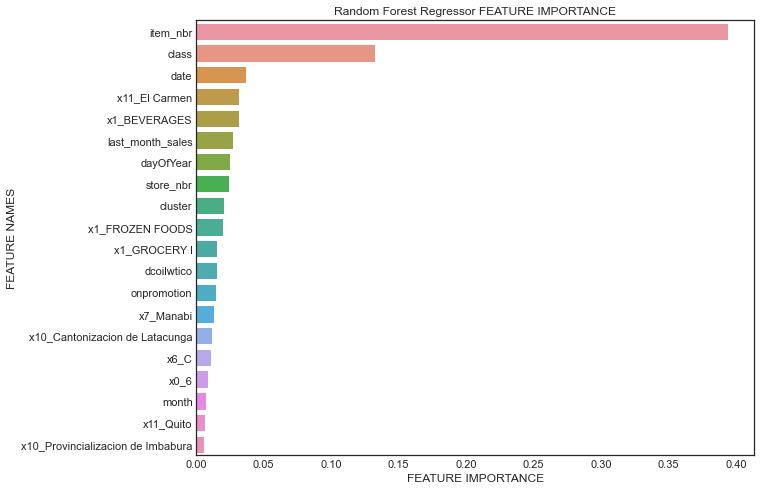

In [217]:
plot_feature_importance(forest_reg2.feature_importances_,X_test_final.columns,'Random Forest Regressor') 

In [218]:
test_final_predictions.shape

(3370464,)

Check for negative predictions

In [219]:
(test_final_predictions<0).sum()

0

In [220]:
(test_final_predictions3<0).sum()

0

In [221]:
(test_final_predictions>0).sum()

3370464

In [222]:
(test_final_predictions3>0).sum()

3370464

In [224]:
test_final_predictions[test_final_predictions<0] = 0

In [225]:
test_final_predictions3[test_final_predictions3<0] = 0

In [226]:
(test_final_predictions<0).sum()

0

In [227]:
(test_final_predictions3<0).sum()

0

### Submission #1 with fined tuned model

In [228]:
result = pd.DataFrame({"id": test_final["id"], 'unit_sales': test_final_predictions})
result.to_csv("final_submission_24_April_2.csv", index=False) # BEST SCORE OF TWO
print("Submitted the final output file in Kaggle's kernel")

Submitted the final output file in Kaggle's kernel


### Submission #2 with model trined using TimeseriesSplit

In [229]:
result = pd.DataFrame({"id": test_final["id"], 'unit_sales': test_final_predictions3})
result.to_csv("final_submission_24_April_3.csv", index=False)
print("Submitted the final output file in Kaggle's kernel")

Submitted the final output file in Kaggle's kernel


## Final Thoughts 

1. Added derived feature like day of the week or weedend/weekday to get the weekly sales distribution pattern into account.
2. Provided justification to predictions, finalised scoring criteria.
3. Submissions are evaluated on the Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE), calculated as follows:

$$ NWRMSLE = \sqrt{ \frac{\sum{i=1}^n wi \left( \ln(\hat{y}i + 1) - \ln(yi +1)  \right)^2  }{\sum{i=1}^n wi}} $$

where for row i, \(\hat{y}i\) is the predicted unitsales of an item and \(yi\) is the actual unitsales; n is the total number of rows in the test set.

The weights, 𝑤𝑖
, can be found in the items.csv file (see the Data page). Perishable items are given a weight of 1.25 where all other items are given a weight of 1.00.
4. Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0

### THE END 